# 1. Import libraries

In [1]:
import os
import time
from matplotlib import pyplot as plt
import numpy as np
from numpy import printoptions
import pandas as pd
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
from torchvision import transforms
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import random
import shutil
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('always')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #Enable processing images(prevent OSError: image file is truncated)

# 2. Set paths
 - To load dataset
 - To save checkpoints & best checkpoints

In [3]:
#Set directories as you want.
path = "/home/ubuntu/Desktop/Project"
dataset_path = os.path.join(path, "datasets/circlin_feeds_dataset/image_dataset")

date = datetime.today().strftime("%Y%m%d")
print(f"Date today: {date}")
checkpoint_path = os.path.join(path, f"autolabeler_classifier/resnext50_model/{date}")
model_path = os.path.join(path, f"autolabeler_classifier/resnext50_model/{date}")
metric_path = os.path.join(path, f"autolabeler_classifier/resnext50_model/{date}")

# Save path for logs
# logdir = os.path.join(path, f"autolabeler_classifier/resnext50_model/{date}/logs")

Date today: 20211227


# 3. Training settings

## 3-1. Set seed number.

In [4]:
# Fix all seeds to make experiments reproducible
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True

## 3-2. Hyperparameters
 - __Adjust: <u>mean</u>, <u>std</u>__

In [13]:
# Initialize the training parameters.s
NUM_WORKERS = 8 # Number of CPU processes for data preprocessing
LEARNING_RATE = 1e-5 # Learning rate
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
save_freq = 1 # Save checkpoint frequency (epochs)
test_freq = 200 # Test model frequency (iterations)
EPOCHS = 56 # Number of epochs for training 
# Note: on the small subset of data overfitting happens after 30-35 epochs


#For normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# Run tensorboard
# %load_ext tensorboard
# %tensorboard --logdir {logdir}

## 3-3. Loss function

In [5]:
# Loss function
def loss_fn(outputs, targets):
    return torch.nn.BCELoss()(outputs, targets) #BCELoss()

## 3-4. Check GPU status & Enable distributed processing
 - __Should be improved!__ 
   - As is : Using DatParallel
   - To be: Use DistributedDataParallel

In [6]:
#Device check(for GPU computing)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
#For multiple GPU utilization: This should be improved...

# dist.init_process_group(
#     backend='nccl',
#     init_method='tcp://localhost:9999', #FREEPORT
#     world_size=2,
#     rank=0,
# )

# dist.init_process_group(
#     backend="nccl",
#     init_method='tcp://127.0.0.1:9999',
#     rank=0,
#     world_size=2)

## 3-5. Optimizer

In [7]:
#Optimizer
def make_optimizer(model, lr):
    optimizer = torch.optim.Adam(
        params =  model.parameters(), 
        lr=lr)

    return optimizer

# 4. Prepare dataset

## 4-1. Define target labels(46)

In [8]:
#Define taret labels
labels = ['간편식', '건강간식', '건강식', '건강음료', '걷기/산책', '격투기', '골프', 
          '기타식단', '기타운동', '농구', '달리기/조깅', '당구', '등산/등반', '루틴기록', '맨몸', '무술', 
          '배구', '배드민턴', '보조제', '보충제', '볼링', '수상스포츠', '스키/스노보드', '승마', '신체기록', 
          '야구', '온라인클래스', '요가', '운동기구', '운동용품', '웨이트', '유산소기록', '의류', '일반간식', 
          '일반식', '일반음료', '일상생활', '자전거', '종합운동', '줄넘기', '축구/풋살', '탁구', '테니스', 
          '폴댄스', '필라테스', '홈트'] #46

## 4-2. Create custom dataset

- At Image.open in __ __getitem__ __  needs .convert('RGB') because Image.open returns grayscale.
    - https://stackoverflow.com/questions/59218671/runtimeerror-output-with-shape-1-224-224-doesnt-match-the-broadcast-shape

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        self.transforms = transforms
        self.df = df
        self.feed_image = df['url'] #Series of file name
        self.labels = self.df[labels].values #df.values: np.array #one-hot encoded: [0, 1, 0, ...., 1, 1]
        
        #self.image_list = self.feed_image.tolist()
        #self.label_list = self.labels.tolist()
        
    def __len__(self):
        return len(self.feed_image)

    def __getitem__(self, index):
        label = torch.FloatTensor(self.labels[index])
        image_url = self.feed_image[index]
        
        #Needs .convert('RGB') because Image.open returns grayscale.
        image = Image.open(image_url).convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label

    
# train_annotations = os.path.join(img_folder, 'small_train.json')
# train_dataset = CustomDataset(img_folder, train_annotations, train_transform)

In [10]:
#Get image dataset
dataset = os.path.join(dataset_path, "20211201_image_dataset(change_url).csv")
whole_df = pd.read_csv(dataset)
print(whole_df.columns)
print(whole_df['deidentification_x'].unique())
print(len(whole_df))

Index(['index', 'seq', 'url', 'deidentification_x', '간편식', '건강간식', '건강식',
       '건강음료', '걷기/산책', '격투기', '골프', '기타식단', '기타운동', '농구', '달리기/조깅', '당구',
       '등산/등반', '루틴기록', '맨몸', '무술', '배구', '배드민턴', '보조제', '보충제', '볼링', '수상스포츠',
       '스키/스노보드', '승마', '신체기록', '야구', '온라인클래스', '요가', '운동기구', '운동용품', '웨이트',
       '유산소기록', '의류', '일반간식', '일반식', '일반음료', '일상생활', '자전거', '종합운동', '줄넘기',
       '축구/풋살', '탁구', '테니스', '폴댄스', '필라테스', '홈트'],
      dtype='object')
['n']
215145


In [11]:
#Drop useless features/columns
copy_df = whole_df.copy()
copy_df.drop(labels=['index', 'seq', 'deidentification_x'], axis=1, inplace=True)
print(copy_df.columns)
copy_df.head(10)

Index(['url', '간편식', '건강간식', '건강식', '건강음료', '걷기/산책', '격투기', '골프', '기타식단',
       '기타운동', '농구', '달리기/조깅', '당구', '등산/등반', '루틴기록', '맨몸', '무술', '배구', '배드민턴',
       '보조제', '보충제', '볼링', '수상스포츠', '스키/스노보드', '승마', '신체기록', '야구', '온라인클래스',
       '요가', '운동기구', '운동용품', '웨이트', '유산소기록', '의류', '일반간식', '일반식', '일반음료',
       '일상생활', '자전거', '종합운동', '줄넘기', '축구/풋살', '탁구', '테니스', '폴댄스', '필라테스',
       '홈트'],
      dtype='object')


,url,간편식,건강간식,건강식,건강음료,걷기/산책,격투기,골프,기타식단,기타운동,...,일상생활,자전거,종합운동,줄넘기,축구/풋살,탁구,테니스,폴댄스,필라테스,홈트
0,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,/home/ubuntu/Desktop/Project/datasets/circlin_...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#Train - validation split
train_size = 0.8
train_df = copy_df.copy().sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = copy_df.drop(train_df.index).reset_index(drop=True)

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, 
                            translate=(0.2, 0.2),
                            scale=(0.5, 1.5),
                            shear=None,
                            resample=False, 
                            fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test preprocessing
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

train_dataset = CustomDataset(train_df, train_transform)
valid_dataset = CustomDataset(val_df, val_transform)

(123.675, 116.28, 103.53)


/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [15]:
train_data_loader =  torch.utils.data.DataLoader(train_dataset, 
                              batch_size=TRAIN_BATCH_SIZE, 
                              num_workers=NUM_WORKERS,  #0?
                              shuffle=True,
                              drop_last=True)
val_data_loader =  torch.utils.data.DataLoader(valid_dataset, 
                             batch_size=VALID_BATCH_SIZE, 
                             num_workers=NUM_WORKERS) #0?

#num_train_batches = int(np.ceil(len(train_dataset) / batch_size))

In [16]:
# #To explore file shape.
# batchlist = []
# datalist = []
# for batch_idx, data in enumerate(train_data_loader):
#     #print(batch_idx, data)
#     batchlist.append(batch_idx)
#     datalist.append(data)

# 5. Make feed image classification model

## 5-1. Define functions that save checkpoint of model

In [17]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min #valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

## 5-2. Define Resnext50 model as a class
 - Use pytorch implemented pretrained model.

In [18]:
class ResNeXt50Class(nn.Module):
    def __init__(self, n_classes):
#         super().__init__()
#         resnet = models.resnext50_32x4d(pretrained=True)
#         resnet.fc = nn.Sequential(
#             nn.Dropout(p=0.2),
#             nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
#         )
#         self.base_model = resnet
        super(ResNeXt50Class, self).__init__()
        self.resnext_model = models.resnext50_32x4d(pretrained=True)
        self.resnext_model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features=self.resnext_model.fc.in_features, 
                      out_features=n_classes)
        )
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        output = self.sigm(self.resnext_model(x))
        
        return output
        #return self.sigm(self.base_model(x))

In [19]:
model = ResNeXt50Class(len(labels)) #or len(labels) #train_dataset.classes
model = model.cuda()
model = nn.DataParallel(model) #Distributed
#model = nn.parallel.DistributedDataParallel(model, device_ids=[0, 1]) #Distributed DataParallel  ===> Should use this!!!!!!!!!!!!!!!!!
model.to(device)

DataParallel(
  (module): ResNeXt50Class(
    (resnext_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [20]:
# optimizer
optimizer = make_optimizer(model, LEARNING_RATE)

In [21]:
val_targets = []
val_outputs = []

## 5-3. Training
 - __<u>Add Train Loss!!!!!!!!!!</u>__

In [22]:
# learning_rate = [
#                  0.00001, 0.00002, 0.00003, 0.00004, 0.00005,                 
#                  0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
#                  0.001, 0.002, 0.003, 0.004, 0.005,
#                  0.01, 0.02, 0.03, 0.04, 0.05,
#                  0.1, 0.2, 0.3, 0.4, 0.5,
#                  0.000001, 0.000002, 0.000003, 0.000004, 0.000005]
train_losses_lr = {}
avg_train_losses_lr = {}
val_losses_lr = {}
avg_val_losses_lr = {}
epoch_list = [int(x) for x in np.linspace(1, EPOCHS, EPOCHS).tolist()]
print(epoch_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


In [23]:
def train_model(n_epochs,
                       training_loader,
                       validation_loader,
                       model,
                       optimizer,
                       checkpoint_path,
                       best_model_path,
                       metric_path,
                       date):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_loss_epoch = []
    avg_train_loss_epoch = []    
    val_loss_epoch = [] #append to val_loss_list
    avg_val_loss_epoch = [] #append to avg_val_list
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0
        valid_loss = 0

        model.train()
        print(f'############# Epoch {epoch}: Training Start   #############')
        for batch_idx, data in enumerate(training_loader):
            images, targets = data[0], data[1]
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if batch_idx%5000==0:
                print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        print('############# Epoch {}: Training End     #############'.format(epoch))
        train_loss_epoch.append(train_loss)
        print('############# Epoch {}: Validation Start   #############'.format(epoch))
        ######################    
        # validate the model #
        ######################

        model.eval()
   
        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                images, targets = data[0], data[1]
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)

                loss = loss_fn(outputs, targets)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                val_targets.extend(targets.cpu().detach().numpy().tolist())
                val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            print('############# Epoch {}: Validation End     #############'.format(epoch))
           # calculate average losses
#             print('before calculate avg train loss', train_loss)
            val_loss_epoch.append(valid_loss) 
            avg_train_loss = train_loss/len(training_loader)
            avg_valid_loss = valid_loss/len(validation_loader)
            #Print training/validation statistics
            print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
                epoch, 
                avg_train_loss,
                avg_valid_loss
            ))
            avg_train_loss_epoch.append(avg_train_loss)
            avg_val_loss_epoch.append(avg_valid_loss) 
            

            # create checkpoint variable and add important data
            checkpoint = {
                    'epoch': epoch + 1,
                    'valid_loss_min': avg_valid_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
              }

            save_ckp(checkpoint, False,  f"{checkpoint_path}_{epoch}", best_model_path)
            
            ## TODO: save the model if validation loss has decreased
            if avg_valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_valid_loss))
                # save checkpoint as best model
                save_ckp(checkpoint, True,  f"{checkpoint_path}_{epoch}", best_model_path)
                valid_loss_min = avg_valid_loss

        now = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        log_text = f"[{now}]: [Learning Rate {lr}, Epoch {epoch}] - train_loss = {train_loss}, avg_train_loss = {avg_train_loss}, validation_loss = {valid_loss}, avg_validation_loss = {avg_valid_loss}\n"
        if os.path.isfile(os.path.join(metric_path, f"metric_logs_resnext_{date}.txt")):
            with open(os.path.join(metric_path, f"metric_logs_resnext_{date}.txt"), 'a', encoding='utf-8') as f:
                f.write(log_text)
        else:
            with open(os.path.join(metric_path, f"metric_logs_resnext_{date}.txt"), 'w', encoding='utf-8') as f:
                f.write(log_text)       
        print('############# Epoch {}  Done   #############\n'.format(epoch))

    train_losses_lr[lr] = train_loss_epoch
    avg_train_losses_lr[lr] = avg_train_loss_epoch
    val_losses_lr[lr] = val_loss_epoch
    avg_val_losses_lr[lr] = avg_val_loss_epoch
    print(f"train_losses_lr for LR {lr}: \n {train_losses_lr}")
    print(f"avg_train_losses_lr for LR {lr}: \n {avg_train_losses_lr}")
    print(f"val_losses_lr for LR {lr}: \n {val_losses_lr}")
    print(f"avg_val_losses_lr {lr}: \n {avg_val_losses_lr}")

    return model

In [24]:
# # Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
# def calculate_metrics(pred, target, threshold=0.5):
#     pred = np.array(pred > threshold, dtype=float)
#     return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
#             'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
#             'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
#             'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
#             'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
#             'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
#             'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
#             'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
#             'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
#             }

### Set checkpoint path, best model's path.

In [25]:
ckpt_path = os.path.join(checkpoint_path, "curr_ckpt")
best_model_path = os.path.join(checkpoint_path, "best_model.pt")

### Training start!

In [28]:
#For hyperparameter tuning
for lr in [LEARNING_RATE]:
    print('\n')
    print(f'##########################################################')
    print(f'##########################################################')    
    print(f'############### Training for learning rate {lr} START! ###############')
    print(f'##########################################################')
    print(f'##########################################################')
    print('\n')
    optimizer = make_optimizer(model, lr)
    train_model(EPOCHS,
               train_data_loader,
               val_data_loader,
               model,
               optimizer,
               os.path.join(checkpoint_path, f"curr_ckpt_{lr}"),
               best_model_path,
               metric_path,
               date)



##########################################################
##########################################################
############### Training for learning rate 1e-05 START! ###############
##########################################################
##########################################################


############# Epoch 1: Training Start   #############
Epoch: 1, Training Loss:  0.09049102663993835
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000097 	Average Validation Loss: 0.000310
Validation loss decreased (inf --> 0.000310).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
Epoch: 2, Training Loss:  0.06278601288795471
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Va

Epoch: 18, Training Loss:  0.036217790096998215
############# Epoch 18: Training End     #############
############# Epoch 18: Validation Start   #############
############# Epoch 18: Validation End     #############
Epoch: 18 	Avgerage Training Loss: 0.000056 	Average Validation Loss: 0.000197
Validation loss decreased (0.000199 --> 0.000197).  Saving model ...
############# Epoch 18  Done   #############

############# Epoch 19: Training Start   #############
Epoch: 19, Training Loss:  0.03264780715107918
############# Epoch 19: Training End     #############
############# Epoch 19: Validation Start   #############
############# Epoch 19: Validation End     #############
Epoch: 19 	Avgerage Training Loss: 0.000055 	Average Validation Loss: 0.000195
Validation loss decreased (0.000197 --> 0.000195).  Saving model ...
############# Epoch 19  Done   #############

############# Epoch 20: Training Start   #############
Epoch: 20, Training Loss:  0.04001079127192497
############# Epoch 20

Epoch: 36, Training Loss:  0.025037916377186775
############# Epoch 36: Training End     #############
############# Epoch 36: Validation Start   #############
############# Epoch 36: Validation End     #############
Epoch: 36 	Avgerage Training Loss: 0.000042 	Average Validation Loss: 0.000157
Validation loss decreased (0.000159 --> 0.000157).  Saving model ...
############# Epoch 36  Done   #############

############# Epoch 37: Training Start   #############
Epoch: 37, Training Loss:  0.02692866139113903
############# Epoch 37: Training End     #############
############# Epoch 37: Validation Start   #############
############# Epoch 37: Validation End     #############
Epoch: 37 	Avgerage Training Loss: 0.000041 	Average Validation Loss: 0.000155
Validation loss decreased (0.000157 --> 0.000155).  Saving model ...
############# Epoch 37  Done   #############

############# Epoch 38: Training Start   #############
Epoch: 38, Training Loss:  0.02763116918504238
############# Epoch 38

Validation loss decreased (0.000135 --> 0.000134).  Saving model ...
############# Epoch 54  Done   #############

############# Epoch 55: Training Start   #############
Epoch: 55, Training Loss:  0.02111469767987728
############# Epoch 55: Training End     #############
############# Epoch 55: Validation Start   #############
############# Epoch 55: Validation End     #############
Epoch: 55 	Avgerage Training Loss: 0.000031 	Average Validation Loss: 0.000132
Validation loss decreased (0.000134 --> 0.000132).  Saving model ...
############# Epoch 55  Done   #############

############# Epoch 56: Training Start   #############
Epoch: 56, Training Loss:  0.016994986683130264
############# Epoch 56: Training End     #############
############# Epoch 56: Validation Start   #############
############# Epoch 56: Validation End     #############
Epoch: 56 	Avgerage Training Loss: 0.000030 	Average Validation Loss: 0.000134
############# Epoch 56  Done   #############

train_losses_lr for LR 

### Check & Visualize validation loss
 - PID was dead at Learning rate 0.004... Evaluation is possible up to 0.003.

In [ ]:
color = ['dodgerblue', 'green', 'violet', 'orange']

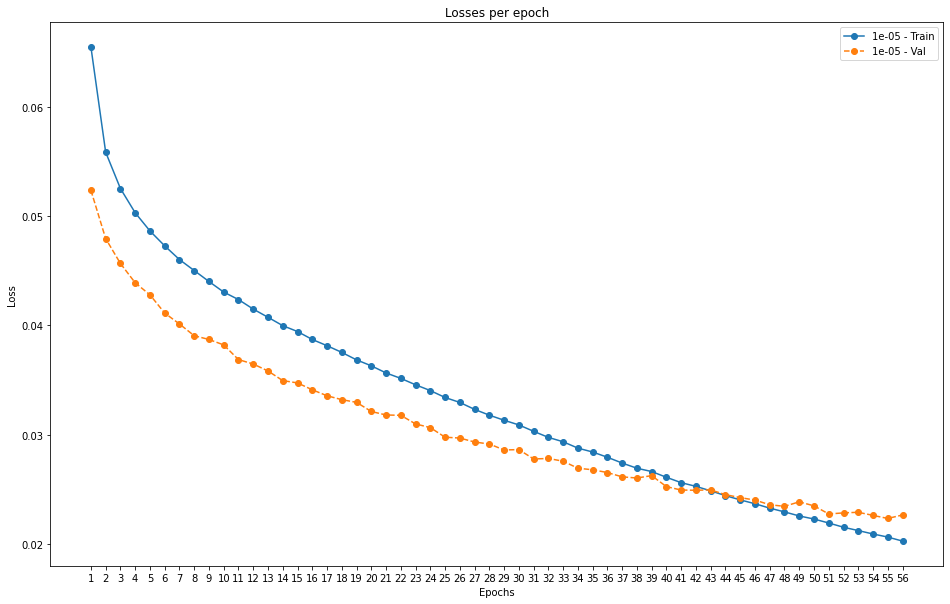

In [30]:
# learning_rate = [
#                  0.00001, 0.00002, 0.00003, 0.00004, 0.00005,                 
#                  0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
#                  0.001, 0.002, 0.003]
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)

for index, lr in enumerate([LEARNING_RATE]):
    plt.title("Losses per epoch")
    plt.plot(epoch_list, 
             train_losses_lr[lr], 
             #color=color[index],
             marker='o',
             label=f"{lr} - Train")    
    plt.plot(epoch_list, 
             val_losses_lr[lr], 
             '--', 
             #color=color[index],
             marker='o',
             label=f"{lr} - Val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

plt.show()

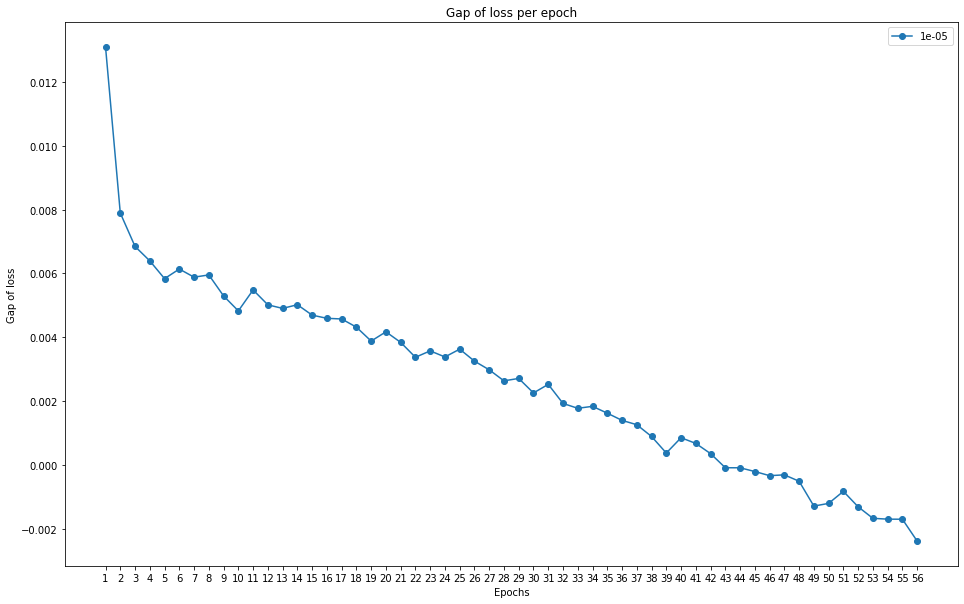

In [31]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate([LEARNING_RATE]):
    plt.title("Gap of loss per epoch")
    plt.plot(epoch_list, 
             np.array(train_losses_lr[lr]) - np.array(val_losses_lr[lr]), 
             #color=color[index], 
             marker='o',
             label=lr)    
    plt.xlabel('Epochs')
    plt.ylabel('Gap of loss')
    plt.legend(loc="upper right")

    plt.show()

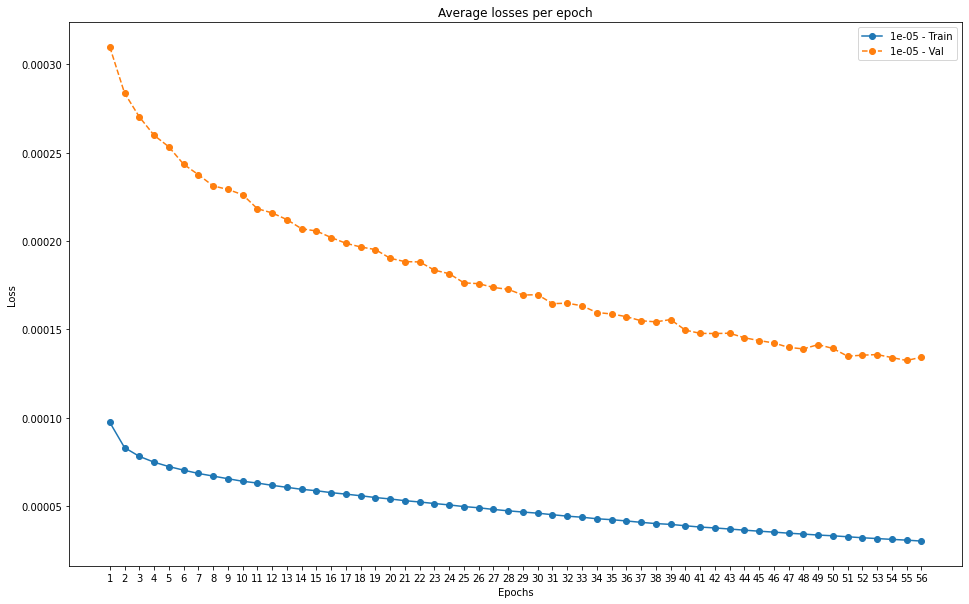

In [32]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate([LEARNING_RATE]):
    plt.title("Average losses per epoch")
    plt.plot(epoch_list, 
             avg_train_losses_lr[lr], 
             #color=color[index], 
             marker='o',
             label=f"{lr} - Train")    
    plt.plot(epoch_list, 
             avg_val_losses_lr[lr], 
             '--',
             #color=color[index],
             marker='o',
             label=f"{lr} - Val")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

plt.show()

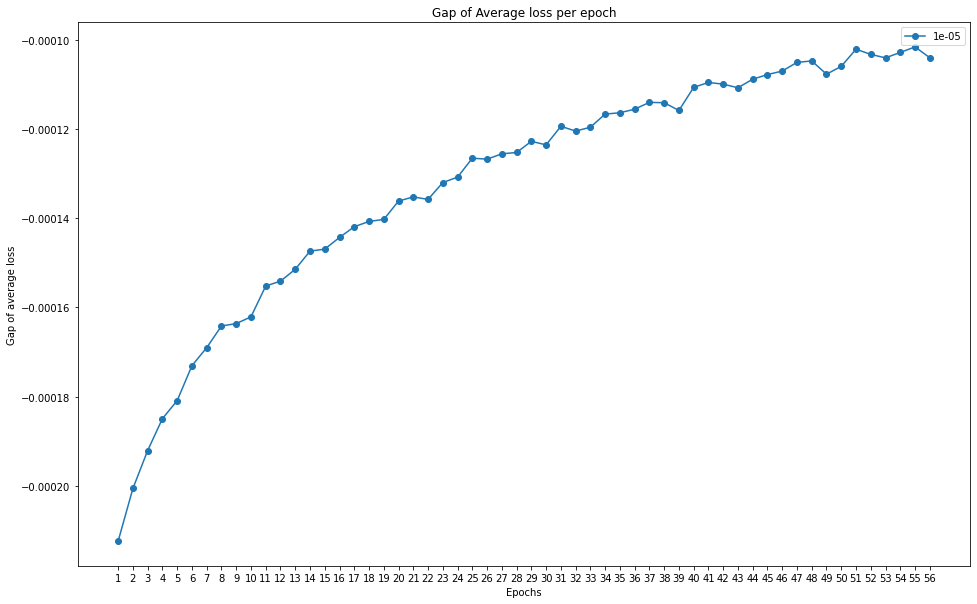

In [33]:
plt.figure(figsize=(16, 10))
plt.xticks(epoch_list)
for index, lr in enumerate([LEARNING_RATE]):
    plt.title("Gap of Average loss per epoch")
    plt.plot(epoch_list, 
             np.array(avg_train_losses_lr[lr]) - np.array(avg_val_losses_lr[lr]), 
             #color=color[index],
             marker='o',
             label=lr)    
    plt.xlabel('Epochs')
    plt.ylabel('Gap of average loss')
    plt.legend(loc="upper right")

plt.show()

- ~~Let's see losses in detail.~~
- ~~Validation loss is always bigger than tran loss but lr = 1e-0.5. So only check lr = 1e-05.~~

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.xticks(epoch_list)

# plt.title("Losses per epoch: lr = 1e-05")
# plt.plot(epoch_list,
#             val_losses_lr[1e-05],
#             label = "1e-05 - Validation")
# plt.plot(epoch_list,
#             train_losses_lr[1e-05],
#             label = "1e-05 - Train")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(loc="upper right")

# plt.show()

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.xticks(epoch_list)
# for index, lr in enumerate(learning_rate[1:]):
#     plt.title("Losses per epoch: lr = [1e-05, 1e-04, 1e-03]")
#     plt.plot(epoch_list, 
#              train_losses_lr[lr], 
#              color=color[index], 
#              label=f"{lr} - Train")    
#     plt.plot(epoch_list, 
#              val_losses_lr[lr], 
#              '--', 
#              color=color[index], 
#              label=f"{lr} - Val")
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend(loc="upper right")

# plt.show()

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.xticks(epoch_list)
# for index, lr in enumerate(learning_rate[1:]):
#     plt.title("Gap of loss per epoch: lr = [1e-05, 1e-04, 1e-03]")
#     plt.plot(epoch_list, 
#              np.array(train_losses_lr[lr]) - np.array(val_losses_lr[lr]), 
#              color=color[index], 
#              label=lr)    
#     plt.xlabel('Epochs')
#     plt.ylabel('Gap of loss')
#     plt.legend(loc="upper right")

# plt.show()

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.xticks(epoch_list)
# for index, lr in enumerate(learning_rate[1:]):
#     plt.title("Average losses per epoch: lr = [1e-05, 1e-04, 1e-03]")
#     plt.plot(epoch_list,
#              avg_train_losses_lr[lr], 
#              color=color[index], 
#              label=f"{lr} - Train")    
#     plt.plot(epoch_list, 
#              avg_val_losses_lr[lr], 
#              '--', 
#              color=color[index], 
#              label=f"{lr} - Val")
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend(loc="upper right")

# plt.show()

In [ ]:
# plt.figure(figsize=(16, 10))
# plt.xticks(epoch_list)
# for index, lr in enumerate(learning_rate[1:]):
#     plt.title("Gap of Average loss per epoch: lr = [1e-05, 1e-04, 1e-03]")
#     plt.plot(epoch_list, 
#              np.array(avg_train_losses_lr[lr]) - np.array(avg_val_losses_lr[lr]), 
#              color=color[index], 
#              label=lr)    
#     plt.xlabel('Epochs')
#     plt.ylabel('Gap of average loss')
#     plt.legend(loc="upper right")

# plt.show()

~~__Optimal loss:  Learning rate = 1e-05, epoch = 38__~~
- ~~Though it is not the least value, but optimal.~~

## 5-5. Evaluate model
 - Test with validation dataset
 - 1st important index: Precision
 - 2nd importand index: Recall
   - __First, get high & stable <u>Precision</u>, then improve <u>Recall</u>.__
 - And other indexes: F1 score, confusion matrix
 
 - For metrics reference here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [34]:
from PIL import Image, ImageFile

def preprocessing(image):
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    try:
        #transformed_image = Image.open(urlopen(image)).convert('RGB') #OR open(image)
        transformed_image = Image.open(image).convert('RGB') #OR open(image)
    except:
        return "Cannot open image"
    
    transformed_image = transform(transformed_image)
    
    return transformed_image


def inference(image, model, device):
    preprocessed_image = preprocessing(image)
    
    if preprocessed_image == "Cannot open image":
        return "Cannot open image."

    #for gpu computation
    if device.type == 'cuda':
        model.cuda()

    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(preprocessed_image.unsqueeze(0))
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist() #1*46 list in a list
        
        return final_output
    #     print(final_output)
    #     print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
#         result_pair = zip(train_df.columns[1:].to_list(), final_output[0])
#         result_dict = {}
#         for label, score in result_pair:
#             if score > 0.1: #Set prediction threshold
#                 result_dict[label] = score
#     return sorted(result_dict.items(), key=(lambda x: x[1]), reverse=True)

In [35]:
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
#from sklearn.metrics import label_ranking_average_precision_score


def get_metrics(models_path, average_param, label_names):
    #Load model
    load_model = ResNeXt50Class(len(label_names))
    load_model = load_model.cuda() #for GPU computation
    load_model = nn.DataParallel(load_model) # Distributed
    

    y_true = valid_dataset.labels
    y_evaluations = {}

    for file in os.listdir(models_path):
        y_pred = []

        if file.split('_')[0] == 'curr' and file.split('_')[2] == '1e-05':
            model = os.path.join(models_path, file)
            # optimizer
            val_lr = float(file.split('_')[2])
            val_optimizer = make_optimizer(load_model, val_lr)            
            print(f"===========================Start evaluating model {file}, at lr {val_lr}===========================")
            #Load model --> This isn't necessary if you evaluate model right after training.
            prediction_model = load_ckp(model,
                                                        load_model,
                                                        val_optimizer)[0] #load_ckp: [model, optimizer, checkpoint['epoch'], valid_loss_min.item()]
            
            #Evaluate.
            for i in tqdm(range(len(valid_dataset))):
                prediction = np.array(inference(valid_dataset.feed_image[i],
                                                            prediction_model,
                                                            device))[0]
                prediction_over_threshold = np.where(prediction > 0.55, 1, 0).tolist()  #Threshold for each class is 0.6 #up to 0.5, Recall=1.0 
                y_pred.append(prediction_over_threshold)
                if i != 0 and i % 5000 == 0:
                    _precision_score = precision_score(y_true[:i+1], y_pred, average=average_param) #average: ['micro', 'macro', 'weighted', 'samples']
                    _recall_score = recall_score(y_true[:i+1], y_pred, average=average_param)
                    _f1_score = f1_score(y_true[:i+1], y_pred, average=average_param)
                    _average_precision_score = average_precision_score(y_true[:i+1], y_pred, average=average_param)
                    print(f'current index number: {i}')
                    print(f'current Precision: {_precision_score}')
                    print(f'current Recall: {_recall_score}')
                    print(f'current f1 score: {_f1_score}')
                    print(f'current AP: {_average_precision_score}')
                    print('\n')
                
                
            #Append evaluation result into y_preds
            _precision_score = precision_score(y_true, y_pred, average=average_param) #average: ['micro', 'macro', 'weighted', 'samples']
            _recall_score = recall_score(y_true, y_pred, average=average_param)
            _f1_score = f1_score(y_true, y_pred, average=average_param)
            _average_precision_score = average_precision_score(y_true, y_pred, average=average_param)            
            _classification_report = classification_report(y_true, y_pred, target_names = label_names)
            result_dict = {}
            result_dict['precision'] = _precision_score
            result_dict['recall'] = _recall_score
            result_dict['f1score'] = _f1_score
            result_dict['AP'] = _average_precision_score
            result_dict['classification_report'] = _classification_report
            y_evaluations[model.split('/')[-1]] = result_dict
            print(f"Number of finished model: {len(y_evaluations)}")
            print(f"===========================Done evaluating!===========================")
        else:
            pass
    
    return y_evaluations

models_path = '/home/ubuntu/Desktop/Project/autolabeler_classifier/resnext50_model/20211227/'
resnext_evaluations_for_20211227 = get_metrics(models_path, 'weighted', labels)

===========================Start evaluating model curr_ckpt_1e-05_1, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6464759212952481
current Recall: 0.7742514404458298
current f1 score: 0.6977065207544706
current AP: 0.5728861934985673




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.6462404794421919
current Recall: 0.7761924942317653
current f1 score: 0.6985767003122398
current AP: 0.5706498570198854




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.6597293194513828
current Recall: 0.7903455703018593
current f1 score: 0.7127434833545396
current AP: 0.585231992075268




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.6745608728790728
current Recall: 0.8091463267715587
current f1 score: 0.7303419564986557
current AP: 0.6054981788137187




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.673941261383766
current Recall: 0.8131740832467844
current f1 score: 0.7313710194154003
current AP: 0.6067586085689817




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.6715395245695202
current Recall: 0.815253055881403
current f1 score: 0.7314121285324297
current AP: 0.6057319467099677




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.6673283294939766
current Recall: 0.8168029892903378
current f1 score: 0.7299580917686921
current AP: 0.6010024100361638




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.6643432072867513
current Recall: 0.817862267802367
current f1 score: 0.7283380089273165
current AP: 0.598031593275399




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 1
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_2, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6573435166877095
current Recall: 0.7995655048644564
current f1 score: 0.7167583008118115
current AP: 0.5902109394982319




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.6618891303023086
current Recall: 0.8001600979422706
current f1 score: 0.7191267339913485
current AP: 0.5902935340980003




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.675662530749467
current Recall: 0.8130246111938171
current f1 score: 0.7330943501392799
current AP: 0.6060270919765451




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.6916994493092414
current Recall: 0.8298918150495145
current f1 score: 0.7501685592645777
current AP: 0.6266493919609476




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.6913159396917076
current Recall: 0.8334265399057282
current f1 score: 0.7513451082967503
current AP: 0.6278660704331885




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.6901951759716712
current Recall: 0.835024906070961
current f1 score: 0.75128499689762
current AP: 0.6267431991966075




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.6894258264060975
current Recall: 0.8365158291161586
current f1 score: 0.7501166543468062
current AP: 0.6225053609581201




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.687165033909558
current Recall: 0.8373727932173936
current f1 score: 0.7485180073061324
current AP: 0.6196468212478198




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 2
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_3, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6721311113876209
current Recall: 0.8091055067535657
current f1 score: 0.7287962582228873
current AP: 0.6037671919215934




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.6815405635610641
current Recall: 0.812167443612563
current f1 score: 0.734655111899632
current AP: 0.6086293078109217




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.6935422628990295
current Recall: 0.8237939881536853
current f1 score: 0.7471519817964698
current AP: 0.6231336180009228




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7100595334260911
current Recall: 0.839168252897381
current f1 score: 0.7637363190344303
current AP: 0.643426564047644




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7100206968539574
current Recall: 0.8419349684429176
current f1 score: 0.7648333989507509
current AP: 0.6442562525217301




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7095546342530317
current Recall: 0.8436952788969926
current f1 score: 0.7653071124667309
current AP: 0.6435327160508123




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7078172026307474
current Recall: 0.8451659409203248
current f1 score: 0.7647208641882379
current AP: 0.6401747930108797




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.706564276220711
current Recall: 0.8460221961847839
current f1 score: 0.7638675178218934
current AP: 0.6380511037034235




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 3
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_4, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6817417624771703
current Recall: 0.8103334277887976
current f1 score: 0.7350693184201009
current AP: 0.6130813862783387




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.6909503605279397
current Recall: 0.8135800725149503
current f1 score: 0.7416741029094583
current AP: 0.6194007101192681




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7040102939633658
current Recall: 0.8262962845649489
current f1 score: 0.7550511618368574
current AP: 0.6348432204439345




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7210670781451114
current Recall: 0.8427824494614847
current f1 score: 0.772354319035594
current AP: 0.6560592090275259




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7208534421268636
current Recall: 0.8456499161140848
current f1 score: 0.7734526358412642
current AP: 0.6564894753713153




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7200007228019141
current Recall: 0.847316434606688
current f1 score: 0.7738086806104056
current AP: 0.6552814787542591




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7188317577660931
current Recall: 0.8494321525244204
current f1 score: 0.7740210041009261
current AP: 0.6528039052310008




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7170684410599795
current Recall: 0.8512355349596493
current f1 score: 0.7735237538537942
current AP: 0.6505093526862085




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 4
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_5, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6757376889145347
current Recall: 0.8288466987815245
current f1 score: 0.7391552013281636
current AP: 0.6143833506326277




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.6828652700803212
current Recall: 0.8312850214248717
current f1 score: 0.7442247410588481
current AP: 0.6191028480191538




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.6962213342978901
current Recall: 0.8425770485572203
current f1 score: 0.757135407392727
current AP: 0.6345667912771404




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7136287520128818
current Recall: 0.8568537214177289
current f1 score: 0.7736384979357656
current AP: 0.6551187420245984




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7149606483091474
current Recall: 0.8586522329631701
current f1 score: 0.7750975928948904
current AP: 0.6562669492527755




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7147927029690481
current Recall: 0.8596589653355095
current f1 score: 0.7756228866146205
current AP: 0.6555473835262533




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7137685832346592
current Recall: 0.8617747440273038
current f1 score: 0.7760903997491577
current AP: 0.6535015880672358




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7124808835895763
current Recall: 0.8630971971721587
current f1 score: 0.775892314413426
current AP: 0.6516846382231195




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 5
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_6, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6907866911938766
current Recall: 0.8339472938509492
current f1 score: 0.7509344345655483
current AP: 0.6257935688930978




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7006877609294543
current Recall: 0.835381645241795
current f1 score: 0.7556040219267723
current AP: 0.6304544832839606




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7127994491999428
current Recall: 0.8465997275981122
current f1 score: 0.7679826583236383
current AP: 0.6454998938197765




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.729978788244184
current Recall: 0.8607811483507216
current f1 score: 0.7842055640944031
current AP: 0.6664341747041618




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7317731392485005
current Recall: 0.8625269633298713
current f1 score: 0.7856815151927861
current AP: 0.6683032378324131




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7315291912033685
current Recall: 0.8637221400520222
current f1 score: 0.7861934730812368
current AP: 0.6679642615894931




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.731336512563653
current Recall: 0.8657614452159585
current f1 score: 0.7869450998986413
current AP: 0.6668946933165056




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7301248467024068
current Recall: 0.8670072012533077
current f1 score: 0.7865460826897384
current AP: 0.6651457954801281




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 6
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_7, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6910468090605907
current Recall: 0.8430150184188155
current f1 score: 0.7521557088184486
current AP: 0.6254689278431022




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.6997286285168677
current Recall: 0.8459292743796205
current f1 score: 0.7587200543289135
current AP: 0.6332587828117819




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7118034466696291
current Recall: 0.8562288175857591
current f1 score: 0.7710136818562702
current AP: 0.6481668483187965




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7297884422652197
current Recall: 0.8693829361732887
current f1 score: 0.7874918893589354
current AP: 0.6698135236312235




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7307969733384948
current Recall: 0.8706758808021091
current f1 score: 0.7881945148309071
current AP: 0.6708663696580549




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7309983896383083
current Recall: 0.8717464850988592
current f1 score: 0.7888931220661682
current AP: 0.6707881240969584




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7314363045787362
current Recall: 0.8734847593268212
current f1 score: 0.789554089528934
current AP: 0.669644746870649




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7297843308878392
current Recall: 0.8745112494898564
current f1 score: 0.7887680998995065
current AP: 0.667618924752729




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 7
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_8, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.6993663363725707
current Recall: 0.8455653159535279
current f1 score: 0.7599271548928201
current AP: 0.6356498862608342




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7064587871942054
current Recall: 0.8491783208551114
current f1 score: 0.7654712094311855
current AP: 0.6415310479656993




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7223592682766112
current Recall: 0.8599980995217129
current f1 score: 0.777668032419813
current AP: 0.6566394433791108




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7393479864328735
current Recall: 0.8731176059561959
current f1 score: 0.7937423562876688
current AP: 0.6777574446149552




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7420739368514566
current Recall: 0.8744307741471599
current f1 score: 0.7952025579834421
current AP: 0.6793327136561182




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7413606540287959
current Recall: 0.8746366093742031
current f1 score: 0.7953573446788591
current AP: 0.6785566143500628




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7411202590637751
current Recall: 0.8758532423208191
current f1 score: 0.7958696434706741
current AP: 0.6772022426047171




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7401053253262102
current Recall: 0.8761963690938532
current f1 score: 0.7954491724324922
current AP: 0.6754386917273635




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 8
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_9, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7061314003945329
current Recall: 0.8485878908094834
current f1 score: 0.7664187425556911
current AP: 0.6422641489044948




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.719078299436402
current Recall: 0.8501200734567029
current f1 score: 0.773024164758741
current AP: 0.6497164147547574




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7310428223434565
current Recall: 0.8598080516930094
current f1 score: 0.7842579369027143
current AP: 0.6641377676742737




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7469042163972285
current Recall: 0.8724670505746572
current f1 score: 0.7993002247505533
current AP: 0.6842494847415653




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.748744241077466
current Recall: 0.8742709914516258
current f1 score: 0.800864514299556
current AP: 0.6859111465455531




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7474083952244653
current Recall: 0.8750106254568947
current f1 score: 0.8008702408224024
current AP: 0.6847663016923543




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7466233481036249
current Recall: 0.8771919501000353
current f1 score: 0.8015096937624497
current AP: 0.6835481238880933




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7444475472786503
current Recall: 0.8783685935833805
current f1 score: 0.8007053460205708
current AP: 0.6813785543043592




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 9
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_10, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7052077504018265
current Recall: 0.8571833380561066
current f1 score: 0.7685744586953697
current AP: 0.6458278706370284




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7172747600231784
current Recall: 0.8588783726515045
current f1 score: 0.7745036520265808
current AP: 0.652454685338694




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7273215176781207
current Recall: 0.8677583858604415
current f1 score: 0.7843304361660558
current AP: 0.6647937717615073




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7427413749956092
current Recall: 0.8801050526467966
current f1 score: 0.7990022883844832
current AP: 0.6842465189412129




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7450276838464175
current Recall: 0.881640968283135
current f1 score: 0.8005954834844158
current AP: 0.6860456654725001




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7437559634110639
current Recall: 0.8823889427245372
current f1 score: 0.8007823830627261
current AP: 0.6851852691992896




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7429759314280076
current Recall: 0.8842826880075321
current f1 score: 0.8014014816007324
current AP: 0.683994789426574




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7414136784804873
current Recall: 0.8854645269158362
current f1 score: 0.8010319158655743
current AP: 0.6823784308602262




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 10
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_11, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7141102341534759
current Recall: 0.8602059129120619
current f1 score: 0.7745639954068478
current AP: 0.6522822988147422




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7227549138685239
current Recall: 0.8618919809765975
current f1 score: 0.7804436020859731
current AP: 0.6588346812421944




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7340748578309639
current Recall: 0.8719077634538025
current f1 score: 0.7916675817264006
current AP: 0.6731394031970256




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7496921355436318
current Recall: 0.8845143724550033
current f1 score: 0.8063439495076883
current AP: 0.6929425148785489




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7513386205738989
current Recall: 0.8858951825517296
current f1 score: 0.8076208091649693
current AP: 0.6944552784713542




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7504599564520904
current Recall: 0.8867921320616786
current f1 score: 0.8077302684703026
current AP: 0.693623347476652




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7497714463832631
current Recall: 0.8882693891961869
current f1 score: 0.808170597132222
current AP: 0.6923030122555291




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7476707192740727
current Recall: 0.8891375610526732
current f1 score: 0.8072084660718487
current AP: 0.6900801187654061




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 11
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_12, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7175929760475678
current Recall: 0.8590724473410787
current f1 score: 0.7763298569573787
current AP: 0.6549639552041742




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7290227708458528
current Recall: 0.8630691717285869
current f1 score: 0.7846071530708171
current AP: 0.6639965538156453




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.739455818460654
current Recall: 0.8715593424345127
current f1 score: 0.7947647546604005
current AP: 0.6769224627452851




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7560497881102134
current Recall: 0.8835987759920969
current f1 score: 0.8097718910854854
current AP: 0.6973582262812871




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7584679269952238
current Recall: 0.8843173284333307
current f1 score: 0.8114581458991178
current AP: 0.6992846607241335




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7578020980130108
current Recall: 0.8844290304483092
current f1 score: 0.8116116516013078
current AP: 0.6983718088075596




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7573163369439463
current Recall: 0.8860038837236672
current f1 score: 0.8123543355581068
current AP: 0.6975877922952423




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.755950676268862
current Recall: 0.8863992416961782
current f1 score: 0.8117890520946918
current AP: 0.6956340288890335




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 12
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_13, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7182643272647408
current Recall: 0.8642674978747521
current f1 score: 0.7787271627660312
current AP: 0.6572534577056489




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.72807032439406
current Recall: 0.8672599708056693
current f1 score: 0.7859231666796689
current AP: 0.665187000820217




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7383009373472406
current Recall: 0.8765639352570397
current f1 score: 0.7960667708631575
current AP: 0.6781058461365337




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.75450593630158
current Recall: 0.8885381779630388
current f1 score: 0.8108545302931633
current AP: 0.698167751175149




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7565746317847118
current Recall: 0.8894303746904211
current f1 score: 0.8123763439691062
current AP: 0.6998705513617132




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7559569168654688
current Recall: 0.889699257068054
current f1 score: 0.8125861996939137
current AP: 0.6989970994418574




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7554848079416276
current Recall: 0.8914616923620101
current f1 score: 0.813560848312691
current AP: 0.6984492861569215




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7536211864463388
current Recall: 0.8921786753380113
current f1 score: 0.8128827561438677
current AP: 0.6963969516776354




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 13
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_14, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7305367835615565
current Recall: 0.8706904694436574
current f1 score: 0.7893534525663904
current AP: 0.6725159088754844




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7376582628966687
current Recall: 0.8725808730046617
current f1 score: 0.7941917532725408
current AP: 0.6775937187008755




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7492021408350603
current Recall: 0.8805232650216971
current f1 score: 0.8045150069159299
current AP: 0.6908268873002384




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7657278592208498
current Recall: 0.8923451316772282
current f1 score: 0.8193262991054718
current AP: 0.7109778325202055




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7679768799573691
current Recall: 0.893005512502996
current f1 score: 0.8209621827269028
current AP: 0.7128415401787429




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7671368524038887
current Recall: 0.8926743849985549
current f1 score: 0.8207711113928343
current AP: 0.711474195503717




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7658141373661238
current Recall: 0.8938595975050018
current f1 score: 0.8208352114793219
current AP: 0.7097906905654126




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7639511381449798
current Recall: 0.8945747047749444
current f1 score: 0.820082675294884
current AP: 0.7075821320908039




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 14
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_15, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7298862620198403
current Recall: 0.8678568055161991
current f1 score: 0.7881419052203588
current AP: 0.6707961302382679




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7388599796175147
current Recall: 0.8721570843339455
current f1 score: 0.7948970390366569
current AP: 0.6779911597741595




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7496233736207967
current Recall: 0.8807133128504007
current f1 score: 0.805207975410203
current AP: 0.6912520847576613




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7653028899702441
current Recall: 0.8919114280895357
current f1 score: 0.8191863223676058
current AP: 0.7103503984102313




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7670116557016424
current Recall: 0.8930454581768794
current f1 score: 0.8205993064174543
current AP: 0.7118515342837801




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7665157194190486
current Recall: 0.8938304347086925
current f1 score: 0.821088357758869
current AP: 0.7112887031671882




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7657558321421085
current Recall: 0.8953307049546899
current f1 score: 0.8216500872910871
current AP: 0.7102598389928126




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7641889843150184
current Recall: 0.8962334943851288
current f1 score: 0.821206139500708
current AP: 0.7085946701424765




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 15
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_16, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7262157054744645
current Recall: 0.8737130442996127
current f1 score: 0.7886318335937901
current AP: 0.6692313470177658




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7359213596433112
current Recall: 0.8768658473419033
current f1 score: 0.7954351115700621
current AP: 0.6765661935891867




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7471771783783724
current Recall: 0.8846409679769409
current f1 score: 0.8056584495281456
current AP: 0.6899076098378558




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7634014580135015
current Recall: 0.8953569621473146
current f1 score: 0.8197656989358313
current AP: 0.7094282454586158




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7656810462728203
current Recall: 0.8969601342174642
current f1 score: 0.8217712307549792
current AP: 0.7119413076224205




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7653626516898299
current Recall: 0.8974855918804509
current f1 score: 0.8222829305142256
current AP: 0.7115462299349217




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7653356882435172
current Recall: 0.8990231846534071
current f1 score: 0.8232751518372293
current AP: 0.7112085570701977




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7635616672923313
current Recall: 0.8996300635869351
current f1 score: 0.8225389668183334
current AP: 0.7092264427653493




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 16
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_17, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7325350821386595
current Recall: 0.8752243317275904
current f1 score: 0.792736847616413
current AP: 0.674610354159999




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7416420663563339
current Recall: 0.8775250741630174
current f1 score: 0.7989068707120911
current AP: 0.6811966611356173




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7524139098566778
current Recall: 0.8854645085679896
current f1 score: 0.8090136079685671
current AP: 0.6944426956009382




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.768076464587514
current Recall: 0.8965375996915885
current f1 score: 0.8230055127531899
current AP: 0.7138212447196507




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7696024867226583
current Recall: 0.8974394823040664
current f1 score: 0.8243205471273458
current AP: 0.7152647746593134




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.769556383512218
current Recall: 0.8977576035769538
current f1 score: 0.8248133258507396
current AP: 0.7149610468529242




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7695487537297216
current Recall: 0.8992585618453571
current f1 score: 0.8258110054919834
current AP: 0.714809006174839




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.768108492588795
current Recall: 0.8998407035374346
current f1 score: 0.8252754857732278
current AP: 0.7132464666758309




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 17
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_18, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7359735913730312
current Recall: 0.8780579956550486
current f1 score: 0.7960799877159106
current AP: 0.6799869719774628




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.743954535293872
current Recall: 0.880915383528747
current f1 score: 0.801858107520205
current AP: 0.6860355533575111




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7539449167428525
current Recall: 0.8878717810649014
current f1 score: 0.8108698021459365
current AP: 0.6979662589020343




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7691435661536463
current Recall: 0.898537455123726
current f1 score: 0.8244195300747582
current AP: 0.7167157925484994




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7708681117879363
current Recall: 0.8993369018135335
current f1 score: 0.8255564060421731
current AP: 0.7181667459875685




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7706976619097042
current Recall: 0.9005457234661091
current f1 score: 0.8264120078735546
current AP: 0.7181912710638554




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7703051163911789
current Recall: 0.9028333529480993
current f1 score: 0.8275764800053376
current AP: 0.7180849186005449




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7683583924016953
current Recall: 0.9039350175752708
current f1 score: 0.8269627586632338
current AP: 0.7161856420631838




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 18
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_19, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7405499802957558
current Recall: 0.8755076981203362
current f1 score: 0.7985271384674517
current AP: 0.6848477671245016




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7506256912738202
current Recall: 0.8793614917361209
current f1 score: 0.8056587181072913
current AP: 0.692412825253531




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7618499349042133
current Recall: 0.8870799151119698
current f1 score: 0.8156038596454549
current AP: 0.7054142344653554




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7761942019593613
current Recall: 0.8978387104546659
current f1 score: 0.8286401010601433
current AP: 0.7233288214902585




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7779337780785758
current Recall: 0.8989374450746984
current f1 score: 0.8300059386249626
current AP: 0.7247894778116466




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.777616582898763
current Recall: 0.8994916781421601
current f1 score: 0.8304859199212912
current AP: 0.7243150763848644




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7768493040354684
current Recall: 0.9009944686359892
current f1 score: 0.8310136086144654
current AP: 0.7234072010194966




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.774742702943232
current Recall: 0.9015916481259627
current f1 score: 0.830065148915776
current AP: 0.7210718502894751




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 19
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_20, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7417224528394369
current Recall: 0.8823084915462359
current f1 score: 0.8013886621469627
current AP: 0.6861660023443781




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7505227269335697
current Recall: 0.8852003578659886
current f1 score: 0.8076507584968643
current AP: 0.6929305865633993




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7605638523918655
current Recall: 0.8924646035919039
current f1 score: 0.8169709338825637
current AP: 0.705222110978229




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7756956792205123
current Recall: 0.9029708695756933
current f1 score: 0.8305066862868961
current AP: 0.7239957714437681




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7774779382100595
current Recall: 0.9041303826795558
current f1 score: 0.831933230871865
current AP: 0.7258946195432177




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7768604333645519
current Recall: 0.9044048894102447
current f1 score: 0.8321383930310721
current AP: 0.7251703370239893




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7763469207873
current Recall: 0.9052606802400848
current f1 score: 0.8324339781830743
current AP: 0.7241508201047948




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.77429005047763
current Recall: 0.9055411471978304
current f1 score: 0.8313307067540672
current AP: 0.7218109328307943




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 20
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_21, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7521283113596549
current Recall: 0.879191461226032
current f1 score: 0.8055989638078987
current AP: 0.6930438106898376




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7596529356043631
current Recall: 0.8823751000612139
current f1 score: 0.8112952426467193
current AP: 0.699053386848105




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7691650761532218
current Recall: 0.8898039339900542
current f1 score: 0.82029336093196
current AP: 0.7107464515872761




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7833474432468442
current Recall: 0.9005373105558634
current f1 score: 0.8333652694563236
current AP: 0.7288803896518958




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7847726181115617
current Recall: 0.901873452105137
current f1 score: 0.8347849954973058
current AP: 0.7304036860559356




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7839632477362318
current Recall: 0.9024328046105983
current f1 score: 0.8349982854396383
current AP: 0.7296493257334085




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7837663141091756
current Recall: 0.9035394845239496
current f1 score: 0.8357600625622792
current AP: 0.729223374701225




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.782127221005532
current Recall: 0.9039350175752708
current f1 score: 0.8350829323668069
current AP: 0.7271989994588746




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 21
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_22, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7539997519172044
current Recall: 0.8790970057617833
current f1 score: 0.8076054129092527
current AP: 0.6966352376093685




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7627981827326618
current Recall: 0.8841173423741583
current f1 score: 0.8147843245251627
current AP: 0.7044694046768747




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7719914164575149
current Recall: 0.8913243166196826
current f1 score: 0.8234790358151766
current AP: 0.7159537286770797




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7852785869561141
current Recall: 0.9015974748813339
current f1 score: 0.835700951855426
current AP: 0.7328181324331647




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7863041105000484
current Recall: 0.9029320124630502
current f1 score: 0.8367666093978514
current AP: 0.7339261824056461




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7853474619901389
current Recall: 0.9034188470104214
current f1 score: 0.8368940596317851
current AP: 0.732854678325993




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7847028040604628
current Recall: 0.9050694362716253
current f1 score: 0.837642739852521
current AP: 0.7323010633029563




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7827270185267854
current Recall: 0.9058439421266736
current f1 score: 0.836944105528277
current AP: 0.7302827616681988




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 22
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_23, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7511444826755775
current Recall: 0.8839142344384623
current f1 score: 0.807902299007097
current AP: 0.6949777907722775




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7608122400591638
current Recall: 0.8886848424918774
current f1 score: 0.8151599939470315
current AP: 0.7030787406962821




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7709847662523724
current Recall: 0.8952519717462228
current f1 score: 0.8241987470659623
current AP: 0.7153063022304552




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.784627602525061
current Recall: 0.904874346432788
current f1 score: 0.8366232285837556
current AP: 0.7328108525347553




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7866576904014637
current Recall: 0.905608372613246
current f1 score: 0.8381831706499075
current AP: 0.7346456089662918




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7867428107468537
current Recall: 0.9061049625133881
current f1 score: 0.8389087251760083
current AP: 0.7345791325072069




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7871507796725873
current Recall: 0.9076585853830764
current f1 score: 0.840192846993419
current AP: 0.734939986979054




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7861796164644921
current Recall: 0.9080556616069195
current f1 score: 0.8399488192375837
current AP: 0.7336019864870991




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 23
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_24, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7532124412955411
current Recall: 0.8874090866156608
current f1 score: 0.8108267301070582
current AP: 0.6983178678451976




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7611774543865254
current Recall: 0.8915101002966521
current f1 score: 0.8172079909771316
current AP: 0.7054816165485128




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7707198701987393
current Recall: 0.8975958949669
current f1 score: 0.82552520069631
current AP: 0.7170029879159769




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.78521597309628
current Recall: 0.9070910536587716
current f1 score: 0.8382843011696995
current AP: 0.7351037866270608




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7871762076185995
current Recall: 0.9080051130462571
current f1 score: 0.8398231639566806
current AP: 0.7368340802967088




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.787081076445401
current Recall: 0.908213053161286
current f1 score: 0.8402706313370207
current AP: 0.7365071752698543




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7872637449603247
current Recall: 0.9099535130045898
current f1 score: 0.8414620554915487
current AP: 0.7367273805336324




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7862948924628685
current Recall: 0.9106360010005398
current f1 score: 0.8412577564751756
current AP: 0.7355376921266534




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 24
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_25, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7618922558653416
current Recall: 0.8875035420799093
current f1 score: 0.8164134521134888
current AP: 0.7063490694714177




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7696093522716655
current Recall: 0.891180486886095
current f1 score: 0.8222720256928626
current AP: 0.7128611953157409




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7795011255563536
current Recall: 0.8986094833866523
current f1 score: 0.8315032150802755
current AP: 0.7256127202006973




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7930758620628587
current Recall: 0.9085367322844132
current f1 score: 0.8437386224580018
current AP: 0.7429188000092056




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7946985442630992
current Recall: 0.9096229128385396
current f1 score: 0.8452613626316505
current AP: 0.7445019325387591




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7950571352445119
current Recall: 0.9103041430781523
current f1 score: 0.8461512131130398
current AP: 0.7448530886407664




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7952642042456568
current Recall: 0.9115864422737436
current f1 score: 0.8471969337364748
current AP: 0.7448822832013872




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7936745873382717
current Recall: 0.9120051606787872
current f1 score: 0.8465477413078827
current AP: 0.7431581495246552




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 25
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_26, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7607218757947493
current Recall: 0.8879758194011523
current f1 score: 0.815858200691495
current AP: 0.7053509774796217




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7702673132583562
current Recall: 0.8917926260771295
current f1 score: 0.8230259339382996
current AP: 0.7134069509960947




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7812050319990891
current Recall: 0.8994013493395838
current f1 score: 0.832921245198465
current AP: 0.7272649681164082




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7949830881199932
current Recall: 0.9090427198033877
current f1 score: 0.8452026870132264
current AP: 0.7448936446278868




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.7965020117409526
current Recall: 0.9103219621315012
current f1 score: 0.8464363336467389
current AP: 0.7464528642355452




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7963866791013721
current Recall: 0.9112731847469441
current f1 score: 0.8472508646047038
current AP: 0.746662230159637




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7959508049287007
current Recall: 0.9124985288925503
current f1 score: 0.8478567669385849
current AP: 0.746224712692526




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7938402566761287
current Recall: 0.9130715254281915
current f1 score: 0.8469154161560124
current AP: 0.7440437627639245




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 26
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_27, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7603129122071859
current Recall: 0.891187305185605
current f1 score: 0.8168632021306589
current AP: 0.7078584362890156




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7696920442220906
current Recall: 0.895653811743655
current f1 score: 0.8241211328313468
current AP: 0.715972308350689




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7800062900433209
current Recall: 0.9023154160463717
current f1 score: 0.8333294993708699
current AP: 0.7284746369433049




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.793424746583366
current Recall: 0.9115967520420211
current f1 score: 0.8453098921323913
current AP: 0.745410893763786




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.794477421620094
current Recall: 0.9126587840536869
current f1 score: 0.8463568812944042
current AP: 0.7463967797489874




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.7943519956514405
current Recall: 0.913109263698339
current f1 score: 0.8469325745504606
current AP: 0.7462772231826734




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.7949616641749748
current Recall: 0.9149994115570201
current f1 score: 0.8483807079132808
current AP: 0.7470132357846525




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7937575370434793
current Recall: 0.9154675548651247
current f1 score: 0.8479997496429567
current AP: 0.7455503154771759




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 27
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_28, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7694294244640285
current Recall: 0.8865589874374232
current f1 score: 0.8201554683487259
current AP: 0.7134145703637653




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7794677087699142
current Recall: 0.8918868013372887
current f1 score: 0.8281728685459557
current AP: 0.7224001306409413




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7893317959819589
current Recall: 0.8993696747014666
current f1 score: 0.8373957446644416
current AP: 0.7350099601480555




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8022460208943696
current Recall: 0.9093800448160374
current f1 score: 0.8494493113827551
current AP: 0.7520767199132656




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8033631798297882
current Recall: 0.9106415275225693
current f1 score: 0.8506069790948937
current AP: 0.7531758936320538




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8029739957216487
current Recall: 0.9117322044847929
current f1 score: 0.8512982085953434
current AP: 0.7531358435527316




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.803742839335057
current Recall: 0.9137489702247852
current f1 score: 0.8528892951454375
current AP: 0.7540791607133026




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8021789051994832
current Recall: 0.9142695401466581
current f1 score: 0.8523057360537448
current AP: 0.7523879955633282




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 28
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_29, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7720747000315132
current Recall: 0.8917540379710966
current f1 score: 0.8241537169165817
current AP: 0.7163968261753222




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7808176539463082
current Recall: 0.8965013890850874
current f1 score: 0.8312174921283794
current AP: 0.724756200804025




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7910161958843236
current Recall: 0.9032973298280067
current f1 score: 0.8403505688758754
current AP: 0.7378700458917814




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8045222951221596
current Recall: 0.9129219574488591
current f1 score: 0.8524226565212374
current AP: 0.7553237396990783




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8055691449882922
current Recall: 0.9138970999440761
current f1 score: 0.8534140598316007
current AP: 0.7562443270891098




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8049915237192883
current Recall: 0.9141803097533194
current f1 score: 0.8535312409874893
current AP: 0.7555197825989503




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8045402228073792
current Recall: 0.915499588089914
current f1 score: 0.8541345352474067
current AP: 0.7551517831944601




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8025451810408527
current Recall: 0.9157966797877802
current f1 score: 0.8532071861837129
current AP: 0.7528741866936657




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 29
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_30, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7662049743925834
current Recall: 0.8961934447907811
current f1 score: 0.8221682705900468
current AP: 0.7131323687011146




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7753603776786999
current Recall: 0.8983378066581909
current f1 score: 0.828525870387558
current AP: 0.7207605648265499




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.784798666854184
current Recall: 0.9048177124576352
current f1 score: 0.8372301299468361
current AP: 0.732925004180562




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.7987524631761287
current Recall: 0.9143676360745007
current f1 score: 0.8495721286712219
current AP: 0.7507830056409999




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8004678083317119
current Recall: 0.9150555244866981
current f1 score: 0.8508231966092781
current AP: 0.7522576927129977




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8003193009655578
current Recall: 0.9156253718909914
current f1 score: 0.8513774253048659
current AP: 0.7521466929045519




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8005515798509037
current Recall: 0.9171472284335648
current f1 score: 0.8524680592078547
current AP: 0.7525034872209538




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.7992207710907623
current Recall: 0.9175607893732145
current f1 score: 0.8519663960853742
current AP: 0.7509544012628745




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 30
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_31, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7757276593724395
current Recall: 0.8951544346840464
current f1 score: 0.8273395203234295
current AP: 0.7209500209274282




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7850414256900194
current Recall: 0.8991853839996233
current f1 score: 0.8345234180688349
current AP: 0.7298391133169654




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7949237499918222
current Recall: 0.9056412530486839
current f1 score: 0.8434530313369637
current AP: 0.7425931086938969




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8087095388868271
current Recall: 0.9148977182372359
current f1 score: 0.8556618270290414
current AP: 0.7603280689927354




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8101385874088345
current Recall: 0.9163337860509707
current f1 score: 0.8572169486140493
current AP: 0.7620192647540555




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8101477447862221
current Recall: 0.9170534332976318
current f1 score: 0.8579341618040848
current AP: 0.7621472410268615




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8106876494711325
current Recall: 0.9185889137342591
current f1 score: 0.8592129128587935
current AP: 0.7628479414909743




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8094466089415016
current Recall: 0.919048434023618
current f1 score: 0.8588085175126364
current AP: 0.7614282283378336




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 31
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_32, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.785577045053063
current Recall: 0.8977991876830075
current f1 score: 0.8337384140448986
current AP: 0.7314731583283882




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7914026101758238
current Recall: 0.8996562603004191
current f1 score: 0.8381164769946391
current AP: 0.7364709903749271




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8000475962527495
current Recall: 0.9070666117639606
current f1 score: 0.8467583399396574
current AP: 0.7483166756704239




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8120713482719282
current Recall: 0.9164879647254416
current f1 score: 0.8580334707357237
current AP: 0.7645410715720083




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8137610717469874
current Recall: 0.9171326995286411
current f1 score: 0.8590712888417473
current AP: 0.7656696262039568




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8132940840347694
current Recall: 0.917529453766512
current f1 score: 0.8594026542236025
current AP: 0.7650815080454065




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8129740121681771
current Recall: 0.9186183358832529
current f1 score: 0.8599671728266376
current AP: 0.7647565508879998




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8116350210137049
current Recall: 0.9189431140483681
current f1 score: 0.8594304344547569
current AP: 0.7631136083046333




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 32
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_33, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7805063919379247
current Recall: 0.8985548313969963
current f1 score: 0.8315586074280398
current AP: 0.726910535721888




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7884320720906236
current Recall: 0.9026227809954325
current f1 score: 0.8379179875313081
current AP: 0.7344545738704359




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.7970739557314945
current Recall: 0.9093788603465205
current f1 score: 0.8462655158707761
current AP: 0.7462195258612306




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.809332436979101
current Recall: 0.9180059272823651
current f1 score: 0.8572674321668354
current AP: 0.7623689133406892




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8107627172672514
current Recall: 0.9186905808100982
current f1 score: 0.8580935315026259
current AP: 0.7635249030504355




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8104102013358305
current Recall: 0.9193995341799698
current f1 score: 0.858660306780543
current AP: 0.763452303874252




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8106747308779082
current Recall: 0.9210309521007415
current f1 score: 0.8597767414870392
current AP: 0.76395544976804




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8096036153762642
current Recall: 0.9213918034729262
current f1 score: 0.8593269936696786
current AP: 0.7627216650313968




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 33
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_34, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7847126407165866
current Recall: 0.9021441390384434
current f1 score: 0.8363645875000565
current AP: 0.7323227990531431




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7905439973659886
current Recall: 0.9058247398408438
current f1 score: 0.8414912505314398
current AP: 0.738019816043956




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.800877385221968
current Recall: 0.9115010611003769
current f1 score: 0.8500654416405867
current AP: 0.7506932388193456




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8142168315325432
current Recall: 0.9202226345083488
current f1 score: 0.8615823783786193
current AP: 0.767778073070975




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8160824643038725
current Recall: 0.9205880003195653
current f1 score: 0.8626995098438257
current AP: 0.7692167452550431




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8165974617532807
current Recall: 0.9211166080141446
current f1 score: 0.8635644389809584
current AP: 0.7698096679449226




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8166206731194894
current Recall: 0.9227227256678828
current f1 score: 0.8645605975018432
current AP: 0.7700948934583464




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.815445705969594
current Recall: 0.9227477981542674
current f1 score: 0.8639600980799607
current AP: 0.7685992533310815




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 34
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_35, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7864307391160497
current Recall: 0.9047888920374043
current f1 score: 0.8383785344047956
current AP: 0.7346811164395646




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7928458096904972
current Recall: 0.9061072656213213
current f1 score: 0.8423741096581897
current AP: 0.7393577761361886




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8011122127870176
current Recall: 0.9119128313959013
current f1 score: 0.8499951088315489
current AP: 0.7500477009391205




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8127115751193801
current Recall: 0.9205358648772378
current f1 score: 0.8606719797756219
current AP: 0.7656332055100478




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8141940450113144
current Recall: 0.92086762003675
current f1 score: 0.8616287606014593
current AP: 0.7667458067789853




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8147136625894019
current Recall: 0.921524625558899
current f1 score: 0.862596914271552
current AP: 0.7673382786604296




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8153629170988057
current Recall: 0.923193480051783
current f1 score: 0.8639451036376299
current AP: 0.7682483189871576




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.814620041783318
current Recall: 0.9236298529469845
current f1 score: 0.8638343635377566
current AP: 0.7674293004758186




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 35
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_36, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7914202616940987
current Recall: 0.9028997827524322
current f1 score: 0.8402972105643999
current AP: 0.738051671104585




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7981037542886257
current Recall: 0.9048829872392522
current f1 score: 0.8450000192422934
current AP: 0.7437393496760861




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.806481868196423
current Recall: 0.9112476639954389
current f1 score: 0.8530257419249825
current AP: 0.7550969130380628




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8181482664965076
current Recall: 0.9194516059080067
current f1 score: 0.8635109170309053
current AP: 0.7704786891763452




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8199699234505746
current Recall: 0.9200886793960215
current f1 score: 0.8648107923016475
current AP: 0.7719613149376662




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8205897609206354
current Recall: 0.9206575882762958
current f1 score: 0.8657369677021012
current AP: 0.7725883163082556




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8213522475520622
current Recall: 0.9220018830175356
current f1 score: 0.8670473196120703
current AP: 0.7734438599612689




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8205564046218786
current Recall: 0.9221553732934873
current f1 score: 0.8667550818429214
current AP: 0.772335596261934




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 36
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_37, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7872742817472365
current Recall: 0.9086615660715972
current f1 score: 0.8406574716680604
current AP: 0.7377346768439831




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7937932279266606
current Recall: 0.911616518340632
current f1 score: 0.8460499949283401
current AP: 0.7439906566209659




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8042320946122363
current Recall: 0.9164423046466694
current f1 score: 0.8543110490871981
current AP: 0.7560453463240335




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8175759353932119
current Recall: 0.9236199792786064
current f1 score: 0.8652467986300436
current AP: 0.7724078047155218




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8199514265830318
current Recall: 0.9233642246544699
current f1 score: 0.8664604460493734
current AP: 0.773920923940908




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8212528341327554
current Recall: 0.9236157154757655
current f1 score: 0.8676317997892938
current AP: 0.7751085041646892




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8226998089177198
current Recall: 0.9248264093209368
current f1 score: 0.8692137951760609
current AP: 0.7765106840457026




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8222061134743973
current Recall: 0.9250780026066694
current f1 score: 0.8690877616590803
current AP: 0.7757713132107337




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 37
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_38, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7890616010258165
current Recall: 0.9088504770000945
current f1 score: 0.8419366247891326
current AP: 0.7391676560568673




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7962406165690274
current Recall: 0.9104393275886424
current f1 score: 0.8469593771882503
current AP: 0.7452349187876927




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8054259232170107
current Recall: 0.9163789553704349
current f1 score: 0.8550244651450588
current AP: 0.7569364689911445




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8175103647312436
current Recall: 0.9242223453726237
current f1 score: 0.8655455139275962
current AP: 0.7726329385813211




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8190253312252235
current Recall: 0.9246424862187426
current f1 score: 0.8663984440310539
current AP: 0.7737273670671572




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8197728851239345
current Recall: 0.925281787116846
current f1 score: 0.8673653613409603
current AP: 0.7745454633938524




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8205011224191356
current Recall: 0.9265770271860657
current f1 score: 0.8685662634643684
current AP: 0.7752729220246996




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8196570484336951
current Recall: 0.9270000921549784
current f1 score: 0.8682917495839083
current AP: 0.7743065207652136




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 38
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_39, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7922324713710802
current Recall: 0.9062057240011334
current f1 score: 0.8422233111475639
current AP: 0.7413326622096947




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7999916549694748
current Recall: 0.9102038894382446
current f1 score: 0.8485389459583964
current AP: 0.7486450654307344




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8094174132808364
current Recall: 0.9152703430363308
current f1 score: 0.8565293280551445
current AP: 0.76038634018486




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8210592564584017
current Recall: 0.922873045322025
current f1 score: 0.8666886463555912
current AP: 0.7755985005110366




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8232917167870952
current Recall: 0.9234041703283534
current f1 score: 0.8682174108613562
current AP: 0.7773392857298596




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8238286735494078
current Recall: 0.9236497169378284
current f1 score: 0.8688485263566315
current AP: 0.7775358157102845




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8236300289229719
current Recall: 0.9248999646934212
current f1 score: 0.8694770715211306
current AP: 0.7774723239795747




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.823042914156971
current Recall: 0.9251306625942943
current f1 score: 0.8692799995711824
current AP: 0.7764911538057363




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 39
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_40, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7921667134482432
current Recall: 0.9114952299990554
current f1 score: 0.8449556998465289
current AP: 0.7435702654499441




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.7983003219574341
current Recall: 0.9152422658567594
current f1 score: 0.8501262386240573
current AP: 0.7493233898552806




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8088328121673302
current Recall: 0.9204333090494441
current f1 score: 0.858741302842829
current AP: 0.7621157572120958




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.821502002197167
current Recall: 0.9271377972676674
current f1 score: 0.869083198849643
current AP: 0.7777126207271231




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8238476416926658
current Recall: 0.9280778141727251
current f1 score: 0.8708250664712893
current AP: 0.7799588256618374




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8244586508072086
current Recall: 0.9284099216266299
current f1 score: 0.871594932200648
current AP: 0.7804566377952049




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8252492338256143
current Recall: 0.9296516417559139
current f1 score: 0.8727754571713942
current AP: 0.7814039707831265




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8250077784150559
current Recall: 0.9299227214681605
current f1 score: 0.8728246434732957
current AP: 0.7809335021688264




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 40
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_41, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8022188814519761
current Recall: 0.9102673089638236
current f1 score: 0.8505431271319494
current AP: 0.7518962626441722




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8063470746939178
current Recall: 0.9130291472430193
current f1 score: 0.85426569657107
current AP: 0.7557118823628214




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8164245135389573
current Recall: 0.9188812517816984
current f1 score: 0.8627082070811621
current AP: 0.7684469849775719




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8289115083070412
current Recall: 0.9266077151049322
current f1 score: 0.8733133981724918
current AP: 0.7845700149569584




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8307062107586065
current Recall: 0.9273987377167053
current f1 score: 0.8746152766141637
current AP: 0.7862250432230966




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8311545124019052
current Recall: 0.9280869077370327
current f1 score: 0.8754446748221825
current AP: 0.7868611770963658




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8311548229972545
current Recall: 0.9288572437330823
current f1 score: 0.8759745609676348
current AP: 0.786765239327966




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.830089834661717
current Recall: 0.929080161666162
current f1 score: 0.8755122116420511
current AP: 0.785455306032912




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 41
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_42, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.7997924199193879
current Recall: 0.9128176064985359
current f1 score: 0.8499456702903259
current AP: 0.7504934863289758




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8045346470085623
current Recall: 0.9156660545274756
current f1 score: 0.8539281197522408
current AP: 0.7551550197016387




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8132353511128394
current Recall: 0.9207183807924995
current f1 score: 0.8615105282615123
current AP: 0.7663249903589521




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8250741812961458
current Recall: 0.9276437847866419
current f1 score: 0.8714584705001291
current AP: 0.7814297940415146




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8271197372464483
current Recall: 0.9285571622593273
current f1 score: 0.8729661216405584
current AP: 0.7834748199683285




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8279861993094435
current Recall: 0.9295149691436732
current f1 score: 0.8741227047295403
current AP: 0.7846329083671186




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8286138406305891
current Recall: 0.9306372837472049
current f1 score: 0.875174323674803
current AP: 0.7853379427202928




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.827838285468608
current Recall: 0.9312787161495018
current f1 score: 0.8750721148892757
current AP: 0.7845903419086753




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 42
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_43, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8054290584677138
current Recall: 0.9113063190705583
current f1 score: 0.8524004105666887
current AP: 0.7555591678473897




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8129199409109195
current Recall: 0.9148184771860433
current f1 score: 0.858289182867037
current AP: 0.7631389139326149




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8205033087985686
current Recall: 0.9203382851350923
current f1 score: 0.8653842057318907
current AP: 0.7735056419676126




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8327504068429474
current Recall: 0.9273787437052743
current f1 score: 0.875583356812414
current AP: 0.7889405997143202




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8339594007062088
current Recall: 0.9281577055204921
current f1 score: 0.8765043630272986
current AP: 0.7900810073643879




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8341133390288327
current Recall: 0.9294979684126418
current f1 score: 0.877466168359965
current AP: 0.7907679014515814




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8343741018013959
current Recall: 0.9305343062257267
current f1 score: 0.8782246749124027
current AP: 0.7910118184513424




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8333826855554186
current Recall: 0.9309627562237522
current f1 score: 0.8778215498034138
current AP: 0.7898469382450646




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 43
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_44, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8063073374431177
current Recall: 0.9113063190705583
current f1 score: 0.852794893795643
current AP: 0.756131976415263




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8124357855642039
current Recall: 0.9137354616942129
current f1 score: 0.857334593747862
current AP: 0.7615465875380075




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8206109712763835
current Recall: 0.9193880459915745
current f1 score: 0.8649812384314378
current AP: 0.7724894670313692




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8318350588910971
current Recall: 0.926149916873479
current f1 score: 0.8744837748372983
current AP: 0.7868687518989783




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8337855277865557
current Recall: 0.9268594711192778
current f1 score: 0.8758575504418056
current AP: 0.7885002838770252




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8344359829998899
current Recall: 0.9284609238197242
current f1 score: 0.8772377055122917
current AP: 0.789764943136347




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8353636708962839
current Recall: 0.9295486642344357
current f1 score: 0.8784897786932608
current AP: 0.7907544244649307




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8346328303159546
current Recall: 0.9302781763846285
current f1 score: 0.8784968539530895
current AP: 0.7901065147668909




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 44
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_45, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8164591618819119
current Recall: 0.9087560215358459
current f1 score: 0.8578947378025792
current AP: 0.7639499144338235




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8228194715415438
current Recall: 0.9132645853934171
current f1 score: 0.8634567754283766
current AP: 0.7710123279901561




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8303549510111469
current Recall: 0.918944601057933
current f1 score: 0.8704370141282657
current AP: 0.7812727645777873




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8407013353128934
current Recall: 0.9263426740235645
current f1 score: 0.8796823136825189
current AP: 0.7953463542355027




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8419994956292524
current Recall: 0.9273787648797636
current f1 score: 0.8807767614884962
current AP: 0.7965950718014554




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8417719040967035
current Recall: 0.92864793186107
current f1 score: 0.8814620090795267
current AP: 0.7968881615797958




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8419400120833959
current Recall: 0.9301076850653172
current f1 score: 0.8824213227925533
current AP: 0.7973681506393592




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8409551788157501
current Recall: 0.9305809713134717
current f1 score: 0.8821132577041118
current AP: 0.7963165407297322




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 45
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_46, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.81081714950364
current Recall: 0.91593463681874
current f1 score: 0.8581945920423533
current AP: 0.7624794608801027




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8177140036314272
current Recall: 0.9192918020436032
current f1 score: 0.8634935451726538
current AP: 0.7691511491622511




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8264172643413875
current Recall: 0.9242342656235153
current f1 score: 0.8708896428376182
current AP: 0.7802677164631575




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8379590687919303
current Recall: 0.9308724670505747
current f1 score: 0.8804442188862268
current AP: 0.7950510301798305




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8398327613739155
current Recall: 0.9318926260286011
current f1 score: 0.8819165216991723
current AP: 0.7970265978673587




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8397882837627529
current Recall: 0.9325921014603628
current f1 score: 0.8824121597679907
current AP: 0.7972112878828321




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8398837527217152
current Recall: 0.9333441214546311
current f1 score: 0.8829673646754345
current AP: 0.7972312903236539




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8388263200754005
current Recall: 0.9338722205400282
current f1 score: 0.8826102838798147
current AP: 0.79617647407294




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 46
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_47, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8110885016337291
current Recall: 0.9166902805327288
current f1 score: 0.8583913601535558
current AP: 0.762923982015128




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8164001567958161
current Recall: 0.9198097659744785
current f1 score: 0.8628727937016956
current AP: 0.7682571586885124




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8251718420707382
current Recall: 0.9246777105571569
current f1 score: 0.8701848612931876
current AP: 0.7792857646385893




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8373114227637592
current Recall: 0.9315953063633954
current f1 score: 0.8802279977349788
current AP: 0.7948456547833003




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8394708279298188
current Recall: 0.9323919469521451
current f1 score: 0.8818990269193162
current AP: 0.7970084596649578




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8399514024275869
current Recall: 0.9329661175430544
current f1 score: 0.8826431684909343
current AP: 0.7975511276049346




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.840365015111873
current Recall: 0.9337560315405438
current f1 score: 0.8834171948928069
current AP: 0.7978779318073209




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8398317386510628
current Recall: 0.9341223554812464
current f1 score: 0.883363782346262
current AP: 0.7972226972650126




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 47
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_48, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8093244908408874
current Recall: 0.9196183999244356
current f1 score: 0.8582867210467677
current AP: 0.7615859817514827




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8154478323357591
current Recall: 0.9228233742995715
current f1 score: 0.8634769967731105
current AP: 0.7682464340435822




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8243283012197141
current Recall: 0.9276551265401792
current f1 score: 0.8709984686612209
current AP: 0.7795615102920546




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8358934819912925
current Recall: 0.9341975278895501
current f1 score: 0.8805669171912428
current AP: 0.7944267804668425




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8385253766010919
current Recall: 0.9345889590157386
current f1 score: 0.8821922949696491
current AP: 0.7966988815431228




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8400670407632663
current Recall: 0.9352102140392037
current f1 score: 0.8835067618242984
current AP: 0.7983242782656538




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8405954822739395
current Recall: 0.9362274920560197
current f1 score: 0.8844454216089684
current AP: 0.7989766370646496




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.840153397825993
current Recall: 0.9365710449058045
current f1 score: 0.884436421164044
current AP: 0.7984721681427723




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 48
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_49, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8138180985695332
current Recall: 0.9150845376405025
current f1 score: 0.8579270802842768
current AP: 0.7645867977549922




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8185639252664044
current Recall: 0.9193859773037623
current f1 score: 0.8626190289011152
current AP: 0.7700188980377622




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8258772506755258
current Recall: 0.924455988090336
current f1 score: 0.8694908689783049
current AP: 0.77982192004399




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8373349991217642
current Recall: 0.9313784545695492
current f1 score: 0.8792831153752673
current AP: 0.7946642292923449




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.839838403915833
current Recall: 0.9319924902133099
current f1 score: 0.8810296348006975
current AP: 0.7968992000922975




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8413708879310354
current Recall: 0.9328301116948029
current f1 score: 0.8826501137877834
current AP: 0.7986011428891518




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8420484999482408
current Recall: 0.9339178533600094
current f1 score: 0.883833069467424
current AP: 0.7994115842181417




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8422300024562474
current Recall: 0.9345699653760582
current f1 score: 0.8843573934466857
current AP: 0.7996117468988341




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 49
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_50, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8148727698230627
current Recall: 0.9194294889959385
current f1 score: 0.8617307642199015
current AP: 0.7672513172576602




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8214882288308155
current Recall: 0.9224937608890145
current f1 score: 0.8667722643762098
current AP: 0.7738273204535164




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8295328266384994
current Recall: 0.9261664185486681
current f1 score: 0.8732781422496275
current AP: 0.7835416028487978




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8412601886113007
current Recall: 0.9329927957015155
current f1 score: 0.883024675837737
current AP: 0.7987707395114544




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8429533514703589
current Recall: 0.9330310777342814
current f1 score: 0.8839189207521443
current AP: 0.8000007673849859




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8444279816686041
current Recall: 0.9343431767566005
current f1 score: 0.8855475081063868
current AP: 0.8020202280032508




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8452965765226707
current Recall: 0.9353448275862069
current f1 score: 0.8867081851436713
current AP: 0.8029887140523124




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8453638366142041
current Recall: 0.9358469700759621
current f1 score: 0.8869865423637782
current AP: 0.8030267499974895




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 50
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_51, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8213748047375241
current Recall: 0.9205629545669217
current f1 score: 0.8656110816938339
current AP: 0.7739681354507618




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8289140873162817
current Recall: 0.9243772660921976
current f1 score: 0.8716025993537613
current AP: 0.7819637264311967




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8369152190801716
current Recall: 0.9294605809128631
current f1 score: 0.8786720770081368
current AP: 0.7924550474883327




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8473852171296298
current Recall: 0.9359082475965593
current f1 score: 0.887643715236927
current AP: 0.8063155229482621




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8487313527320253
current Recall: 0.9364264600143805
current f1 score: 0.8886817833453324
current AP: 0.8073744749677708




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8493522389149766
current Recall: 0.937216300300913
current f1 score: 0.8895483822276276
current AP: 0.8082719258154623




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8497475108261925
current Recall: 0.9383605978580676
current f1 score: 0.8904556223749502
current AP: 0.808967016186937




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8489865607053388
current Recall: 0.9389012493582064
current f1 score: 0.8903497345222883
current AP: 0.8082797457468851




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 51
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_52, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8214851805367146
current Recall: 0.9210352318881647
current f1 score: 0.8656191275545368
current AP: 0.7743919837763928




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8283015282547398
current Recall: 0.9240005650515609
current f1 score: 0.8709466340495323
current AP: 0.7810955640489078




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8345534736566229
current Recall: 0.9286053656836971
current f1 score: 0.8770178731199536
current AP: 0.7900135525346055




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8460623735877583
current Recall: 0.9348962725586102
current f1 score: 0.886469858060464
current AP: 0.8045880935325649




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8481863455069842
current Recall: 0.9357074378844771
current f1 score: 0.8880839320266087
current AP: 0.80660523658347




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8490550188512037
current Recall: 0.9366042739837813
current f1 score: 0.8891939908289348
current AP: 0.807726762992117




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8499924926379341
current Recall: 0.9374485112392609
current f1 score: 0.8902739146347812
current AP: 0.808689484210109




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8495872974380976
current Recall: 0.9379402045840519
current f1 score: 0.890383586702932
current AP: 0.8082313224142481




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 52
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_53, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.824957675240355
current Recall: 0.9204684991026731
current f1 score: 0.8678259788385005
current AP: 0.776794051907794




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8316878525061819
current Recall: 0.9240005650515609
current f1 score: 0.8733860067452532
current AP: 0.783718308409365




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8386615180946356
current Recall: 0.9281935953881727
current f1 score: 0.8795364278596631
current AP: 0.7930721786144337




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8495304128597609
current Recall: 0.934679420764764
current f1 score: 0.8886068349271519
current AP: 0.807349153822579




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8511668126818773
current Recall: 0.9353678996564672
current f1 score: 0.8898551992695855
current AP: 0.8090145083388244




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8522152266699949
current Recall: 0.9362982608252155
current f1 score: 0.8910342792693474
current AP: 0.8104092631921954




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8530604788139471
current Recall: 0.9370513122278451
current f1 score: 0.8919266610535118
current AP: 0.8111014044846986




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8523784171866432
current Recall: 0.937360944720178
current f1 score: 0.8916734080554979
current AP: 0.8103686151474803




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 53
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_54, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8269170732395007
current Recall: 0.9208463209596676
current f1 score: 0.8691083585735268
current AP: 0.7792716896629583




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8325763828614717
current Recall: 0.924895230023073
current f1 score: 0.8740031872020754
current AP: 0.7856337267161704




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8403722973409482
current Recall: 0.9294605809128631
current f1 score: 0.8808157438364759
current AP: 0.7957948956316734




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.850759788577335
current Recall: 0.9356913958027131
current f1 score: 0.8895804430447758
current AP: 0.8094574036715034




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8527686488216756
current Recall: 0.9362067588080211
current f1 score: 0.8910314435597245
current AP: 0.8112193476709604




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8538480131865497
current Recall: 0.9367572805630642
current f1 score: 0.8920242471469859
current AP: 0.8122209917332399




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8540908038809248
current Recall: 0.9374485112392609
current f1 score: 0.8926735590312468
current AP: 0.8124322263489564




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8534872576580158
current Recall: 0.9379796995747706
current f1 score: 0.8926685612143593
current AP: 0.8118346597054171




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 54
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_55, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.828404700429329
current Recall: 0.9217908756021536
current f1 score: 0.8706960488587288
current AP: 0.7814495245070634




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8343783426323805
current Recall: 0.925554456844187
current f1 score: 0.8758478046741631
current AP: 0.7879601903985741




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8418981573545514
current Recall: 0.9299040258465047
current f1 score: 0.8823001115634732
current AP: 0.7979262123631126




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8519954451978792
current Recall: 0.9367756547719442
current f1 score: 0.8910829802246669
current AP: 0.8115876365281958




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8538039631903738
current Recall: 0.9372852920028761
current f1 score: 0.892346069134799
current AP: 0.8131060059312475




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8545250464455368
current Recall: 0.9379473317352646
current f1 score: 0.8931625252046601
current AP: 0.8139307151721108




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.8547601393016117
current Recall: 0.9391255737319054
current f1 score: 0.8939441140246751
current AP: 0.8143443294954527




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8542857885431206
current Recall: 0.9397306441632987
current f1 score: 0.893932352529548
current AP: 0.8138915540717615




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 55
===========================Done evaluating!===========================
===========================Start evaluating model curr_ckpt_1e-05_56, at lr 1e-05===========================


  0%|          | 0/43029 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 5000
current Precision: 0.8295279061697499
current Recall: 0.9198073108529329
current f1 score: 0.869848621859616
current AP: 0.7814124305613229




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 10000
current Precision: 0.8343790751227246
current Recall: 0.9241889155718793
current f1 score: 0.874682707995155
current AP: 0.7875294964123449




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 15000
current Precision: 0.8412878670096843
current Recall: 0.9277184758164138
current f1 score: 0.8804790955079267
current AP: 0.7962849690306183




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 20000
current Precision: 0.8510253839522802
current Recall: 0.934366190395875
current f1 score: 0.8890161687428371
current AP: 0.8095041527555484




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 25000
current Precision: 0.8528014764271524
current Recall: 0.9350882799392826
current f1 score: 0.8902693376008975
current AP: 0.8109694007368788




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 30000
current Precision: 0.8545145017129357
current Recall: 0.9361792557079954
current f1 score: 0.8918921551259601
current AP: 0.8129841382630545




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 35000
current Precision: 0.855525177131295
current Recall: 0.9375220666117453
current f1 score: 0.8932716322805484
current AP: 0.814367560269355




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

current index number: 40000
current Precision: 0.8554102066411438
current Recall: 0.9381245145407391
current f1 score: 0.8935480478220783
current AP: 0.8141671165049398




/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true 

Number of finished model: 56
===========================Done evaluating!===========================


/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tf-bert-text-classification/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav

- Compare metrics

In [36]:
#1. precision
precisions = []

for chekpoint, metrics in resnext_evaluations_for_20211227.items():
    precisions.append(metrics['precision'])

max_precision = max(precisions)
max_precision_index = precisions.index(max_precision)

print(f"max precision: {max_precision} | Checkpoint: {list(resnext_evaluations_for_20211227.keys())[max_precision_index]}")
print("===== Check if this max metric value is correct. =====")
sorted(precisions, reverse=True)

max precision: 0.8548541603502191 | Checkpoint: curr_ckpt_1e-05_56
===== Check if this max metric value is correct. =====


[0.8548541603502191,
 0.853628740873477,
 0.8529793935091872,
 0.8515992125110445,
 0.8489401280767137,
 0.8483528499087127,
 0.844517727789971,
 0.8419229139045894,
 0.8399943949351331,
 0.8395961417630916,
 0.8389045463311563,
 0.8379955022567072,
 0.8338445819834557,
 0.8326371657806623,
 0.8291302282872552,
 0.8270096293892207,
 0.8241700098507632,
 0.8222896749781077,
 0.82173902361965,
 0.8197391952931047,
 0.81867265103008,
 0.8144901009832535,
 0.8136402306650027,
 0.8105856669326107,
 0.8084700555975782,
 0.8080950746128839,
 0.8014101583547979,
 0.8009659279529716,
 0.7985490050605475,
 0.7926788103182538,
 0.7925914606538604,
 0.7925672134925975,
 0.7855951151982818,
 0.7852622202213833,
 0.7817545419830197,
 0.7809508121041865,
 0.7736910725356545,
 0.7734057995180941,
 0.7671941374151856,
 0.7671769775732533,
 0.7631907796757822,
 0.7630259268982329,
 0.7625475298975799,
 0.7548676996729722,
 0.7523829827931652,
 0.746600266429587,
 0.7432087267482831,
 0.7404397804835073,

In [38]:
#2. recall
recalls = []

for chekpoint, metrics in resnext_evaluations_for_20211227.items():
    recalls.append(metrics['recall'])

max_recall = max(recalls)
max_recall_index = recalls.index(max_recall)

print(f"max recall: {max_recall} | Checkpoint: {list(resnext_evaluations_for_20211227.keys())[max_recall_index]}")
print("===== Check if this max metric value is correct. =====")
sorted(recalls, reverse=True)

max recall: 0.9394825841171098 | Checkpoint: curr_ckpt_1e-05_55
===== Check if this max metric value is correct. =====


[0.9394825841171098,
 0.9382236046310697,
 0.9378533165469402,
 0.9374953713989483,
 0.9373842849737095,
 0.9369646251450295,
 0.9361006196153941,
 0.9350267841714187,
 0.9339652916635809,
 0.9336937470685527,
 0.9333604877928362,
 0.9305092695450393,
 0.9303488113752499,
 0.930101952652497,
 0.9297316645683675,
 0.9290034313362463,
 0.9284726850823274,
 0.9263126712582389,
 0.9243871732207658,
 0.9242514009232516,
 0.9230664790540374,
 0.9220420153546126,
 0.9213137821224913,
 0.9207213211878842,
 0.918585993236071,
 0.9181416475351156,
 0.9170678120911402,
 0.9152780863511812,
 0.9148831123947765,
 0.9137228763978376,
 0.9126860697622751,
 0.9114888049569232,
 0.9097607938976524,
 0.9073786072230863,
 0.9054160803772001,
 0.9051692216544471,
 0.9034288676590387,
 0.9034288676590387,
 0.9010960527290232,
 0.8994297563504406,
 0.8991211829469994,
 0.8959613912957615,
 0.8940605791305636,
 0.8915426201584833,
 0.8887654595275124,
 0.8857537831099261,
 0.8850255498778049,
 0.878212249129

In [39]:
#3. f1-score
f1_scores = []

for chekpoint, metrics in resnext_evaluations_for_20211227.items():
    f1_scores.append(metrics['f1score'])

max_f1score = max(f1_scores)
max_f1score_index = f1_scores.index(max_f1score)

print(f"max f1score: {max_f1score} | Checkpoint: {list(resnext_evaluations_for_20211227.keys())[max_f1score_index]}")
print("===== Check if this max metric value is correct. =====")
sorted(f1_scores, reverse=True)

max f1score: 0.8934593336162053 | Checkpoint: curr_ckpt_1e-05_55
===== Check if this max metric value is correct. =====


[0.8934593336162053,
 0.893071740510533,
 0.8921954854502152,
 0.8910472662660496,
 0.8897729059760986,
 0.8897151321629831,
 0.8861122958760942,
 0.8839174966762018,
 0.8839098260356533,
 0.882669376085969,
 0.8819082866457703,
 0.8813183308083212,
 0.8777850078142789,
 0.8771051795422375,
 0.8747014849086266,
 0.8742487781491576,
 0.8719344837199405,
 0.8685048549792461,
 0.8684478340426984,
 0.8673743755125274,
 0.865905020641426,
 0.8630666015876466,
 0.8630216546878791,
 0.858413181089355,
 0.8583208583437705,
 0.8578390126696263,
 0.8523296474798754,
 0.8513457177398804,
 0.8513381993508937,
 0.8470650690785615,
 0.8460025423732386,
 0.8457458815565997,
 0.8404758707683153,
 0.8391103923650881,
 0.8361594528592675,
 0.8341741837108672,
 0.8306398636940175,
 0.8291816459841643,
 0.8260089293634567,
 0.8245368933065268,
 0.8217176695490968,
 0.8204996136653103,
 0.8192769929243309,
 0.8118785251529642,
 0.8108359500251607,
 0.8063021915969749,
 0.8002139761974766,
 0.79982321240249

In [40]:
#4. AP
aps = []

for chekpoint, metrics in resnext_evaluations_for_20211227.items():
    aps.append(metrics['AP'])

max_ap = max(aps)
max_ap_index = aps.index(max_ap)

print(f"max AP: {max_ap} | Checkpoint: {list(resnext_evaluations_for_20211227.keys())[max_ap_index]}")
print("===== Check if this max metric value is correct. =====")
sorted(aps, reverse=True)

max AP: 0.8133792816560235 | Checkpoint: curr_ckpt_1e-05_56
===== Check if this max metric value is correct. =====


[0.8133792816560235,
 0.8130352233961821,
 0.8109875309208382,
 0.8093898094163089,
 0.8072147479463281,
 0.8071986892780731,
 0.8016591579434501,
 0.7988719067845229,
 0.797639773549,
 0.7960247440665013,
 0.7950784134266309,
 0.7950230579851266,
 0.7889625123511446,
 0.7887349471827949,
 0.7841584975204938,
 0.7833390138697389,
 0.7795754468680158,
 0.775288121038021,
 0.7747533059774661,
 0.7729223404485408,
 0.7709880474653587,
 0.7672275044397048,
 0.7661529531762249,
 0.7615896144328802,
 0.7612297223768103,
 0.7599109931822404,
 0.7514545342375998,
 0.7508917034546784,
 0.7499374636959255,
 0.7441032520245363,
 0.7425968445651943,
 0.7419011292621616,
 0.7343172898812741,
 0.73235185612202,
 0.7290703746649558,
 0.7257764083893133,
 0.7207766182331787,
 0.7197867163187168,
 0.7148187122911804,
 0.712136479983082,
 0.7080221014944407,
 0.7074900955587788,
 0.7063131522270559,
 0.6949187261153886,
 0.6942014426882837,
 0.6887784778447956,
 0.681159610839787,
 0.6800736480845399,
 

- f1-score, precision, AP is best at __learning rate = 1e-05, epoch=56__.
- Recall is best at __learning rate = 1e-05, epoch=55__.

- Now, compare best precision, f1-score, AP with precision, f1-score, AP of __learning rate = 1e-05, epoch=55__.
- Plus, compare best recall with recall of __learning rate = 1e-05, epoch=56__.

In [41]:
precision_1e05_55 = resnext_evaluations_for_20211227['curr_ckpt_1e-05_55']['precision']
print(f"Precision of curr_ckpt_1e-05_55: {precision_1e05_55}, And (max_precision - precision_1e05_55) = {max_precision - precision_1e05_55} \n")
print(max_precision, precision_1e05_55, '\n')

f1_1e05_55 = resnext_evaluations_for_20211227['curr_ckpt_1e-05_55']['f1score']
print(f"F1-score of curr_ckpt_1e-05_55: {f1_1e05_55}, And (max_f1score - f1_1e05_55) = {max_f1score - f1_1e05_55} \n")
print(max_f1score, f1_1e05_55, '\n')

AP_1e05_55 = resnext_evaluations_for_20211227['curr_ckpt_1e-05_55']['AP']
print(f"AP of curr_ckpt_1e-05_55: {AP_1e05_55}, And (max_ap - AP_1e05_55) = {max_ap - AP_1e05_55} \n")
print(max_ap, AP_1e05_55, '\n')


recall_1e05_56 = resnext_evaluations_for_20211227['curr_ckpt_1e-05_56']['recall']
print(f"Recall of curr_ckpt_1e-05_56: {recall_1e05_56}, And (max_recall - recall_1e05_56) = {max_recall - recall_1e05_56} \n")
print(max_recall, recall_1e05_56, '\n')

Precision of curr_ckpt_1e-05_55: 0.853628740873477, And (max_precision - precision_1e05_55) = 0.0012254194767421511 

0.8548541603502191 0.853628740873477 

F1-score of curr_ckpt_1e-05_55: 0.8934593336162053, And (max_f1score - f1_1e05_55) = 0.0 

0.8934593336162053 0.8934593336162053 

AP of curr_ckpt_1e-05_55: 0.8130352233961821, And (max_ap - AP_1e05_55) = 0.0003440582598414066 

0.8133792816560235 0.8130352233961821 

Recall of curr_ckpt_1e-05_56: 0.9378533165469402, And (max_recall - recall_1e05_56) = 0.001629267570169679 

0.9394825841171098 0.9378533165469402 



- Gap of f1-score, recall, AP is less than gap of precision.
- So, let's take highest f1-score, recall, AP and save the metric records into a json file.

In [42]:
import json

with open(os.path.join(models_path, 'metric_resnext50_20211227.json'), 'w') as f:
    json.dump(resnext_evaluations_for_20211227, f, ensure_ascii=False)

# 6. Inference

## 6-1. Define preprocessing function for input image.

In [ ]:
def preprocessing(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    try:
        transformed_image = Image.open(urlopen(image)).convert('RGB') #OR open(image)
    except:
        return "Cannot open image"
    
    transformed_image = transform(transformed_image)
    
    return transformed_image

## 6-2. Load saved model for inference

In [ ]:
#Load model
load_model = ResNeXt50Class()
load_model = load_model.cuda() #for GPU computation
load_model = nn.DataParallel(load_model) # Distributed
best_model_path = os.path.join(checkpoint_path, "20211126/curr_ckpt_1e-05_16") #currently best model state.

best_optimizer = make_optimizer("loaded_model or best_model_path", "LEARNING_RATE") # <-- Parameter shoud be changed!

predicton_model = load_ckp(best_model_path,  #Path to the saved checkpoint
                        load_model,
                        best_optimizer)[0] #load_ckp: [model, optimizer, checkpoint['epoch'], valid_loss_min.item()]

## 6-3. Define inference function
 - Return dictionaries of predicted labels: {label1: score1, label2: score2, ....}
 - __Labeles which has lower score than threshold will be ignored.__

In [ ]:
def inference(image, model, device):
    preprocessed_image = preprocessing(image)
    
    if preprocessed_image == "Cannot open image":
        return "Cannot open image."

    #for gpu computation
    if device.type == 'cuda':
        model.cuda()

    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(preprocessed_image)
        final_output = torch.sigmoid(output).cpu().detach().numpy().tolist() #1*46 list in a list
    #     print(final_output)
    #     print(train_df.columns[1:].to_list()[int(np.argmax(final_output, axis=1))])
        result_pair = zip(train_df.columns[1:].to_list(), final_output[0])
        result_dict = {}
        for label, score in result_pair:
            if score > 0.1: #Set prediction threshold
                result_dict[label] = score
    return sorted(result_dict.items(), key=(lambda x: x[1]), reverse=True)

- Reference code for inference!

In [ ]:
# model.eval()
# for sample_id in [1,2,3,4,6]:
#     test_img, test_labels = test_dataset[sample_id]
#     test_img_path = os.path.join(img_folder, test_dataset.imgs[sample_id])
#     with torch.no_grad():
#         raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
#         raw_pred = np.array(raw_pred > 0.5, dtype=float)

#     predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0)[:, 0]]
#     if not len(predicted_labels):
#         predicted_labels = ['no predictions']
#     img_labels = np.array(dataset_val.classes)[np.argwhere(test_labels > 0)[:, 0]]
#     plt.imshow(Image.open(test_img_path))
#     plt.title("Predicted labels: {} \nGT labels: {}".format(', '.join(predicted_labels), ', '.join(img_labels)))
#     plt.axis('off')
#     plt.show()

## 6-4. Demo test

In [ ]:
test_image = ""

inference(test_image, #Input sentence
         predicton_model,
          device) #CPU or GPU